<center><img src="assets/header.png" width="25%" style="border-radius:20px;" /></center>

# Intro

We are Gal Elharar (207906553) and Roy Wolfer (324074566), computer science students with a strong passion for data science and its applications in healthcare.  
For our semester project, we sought to tackle a meaningful challenge while expanding our skill set.  
After exploring Kaggle competitions, we were immediately drawn to the [Equity in post-HCT Survival Predictions](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions) challenge.

This competition focuses on predicting survival probabilities for patients undergoing hematopoietic cell transplantation (HCT),  
with an emphasis on ensuring equitable outcomes across different racial groups.  
The evaluation metric used in this challenge is the Stratified Concordance Index (C-index),  
which adjusts for racial stratification to promote fairness and equity in the predictions.  
This makes the challenge particularly impactful in addressing disparities in healthcare outcomes.

We are excited to dive into this project, combining our data science skills with our interest in advancing equity in medicine.

### The problem

We couldn’t explain the problem any better as it was outlined in the kaggle challenge description:

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge.  
Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography.  
Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

This competition aims to encourage participants to advance predictive modeling by ensuring that survival predictions are both precise and fair for patients across diverse groups.  
By using synthetic data, which mirrors real-world situations while protecting patient privacy, participants can build and improve models that more effectively consider diverse backgrounds and conditions.

You’re challenged to develop advanced predictive models for allogeneic HCT that enhance both accuracy and fairness in survival predictions.  
The goal is to address disparities by bridging diverse data sources, refining algorithms, and reducing biases to ensure equitable outcomes for patients across diverse race groups.  
Your work will help create a more just and effective healthcare environment, ensuring every patient receives the care they deserve.

### Risk Score

In this challenge, survival predictions are expressed as **risk scores**, representing the likelihood of an adverse event (death, relapse, rejection, or moderate to severe GVHD) within a specific timeframe after hematopoietic cell transplantation (HCT). Higher scores indicate a higher likelihood of an adverse event and shorter survival time, while lower scores suggest a lower probability and longer survival time.

**Stratification for Fairness:**

Risk scores are stratified by racial group to ensure fair and unbiased predictions across diverse patient populations. This is critical for equitable healthcare applications.

**Clinical Implications:**

These risk scores can guide clinical decision-making by identifying patients at higher risk, enabling personalized follow-up and care to improve outcomes and reduce disparities.

# EDA

In [7]:
# Standard library
import datetime
import itertools
import time
import warnings

# Data handling and numerical operations
import math
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, kruskal, rankdata

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Machine Learning
import catboost
import optuna
import xgboost

# Scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, quantile_transform

# Survival analysis
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv

# Model explanibility
import shap
import shap.plots as shap_plots

# Other utilities
import humanize
import networkx as nx
from itables import show

# Random
import random
RANDOM_SEED = 917
random.seed(RANDOM_SEED)

### Reading the data

We read the data and observe:
1. The training dataset has 59 columns, many of which are categorical and have missing values.
2. Two columns are missing from the test dataset: `efs` and `efs_time`. These two columns together make up the target.

In [8]:
train = pd.read_csv('../datasets/train.csv', index_col='ID')
test = pd.read_csv('../datasets/test.csv', index_col='ID')
data_dictionary = pd.read_csv('../datasets/data_dictionary.csv')
train.tail()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
ID,,,,,,,,,,,,,,,,,,,,,
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,Bi-directional non-permissive,NaN,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,18.633
28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,5.0,Peripheral blood,...,GvH non-permissive,Related,"N/A, Mel not given",6.0,Yes,1.0,Yes,8.0,1.0,4.892
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,Peripheral blood,...,GvH non-permissive,Unrelated,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,23.157
28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,3.0,Peripheral blood,...,Permissive mismatched,Related,MEL,4.0,No,1.0,No,5.0,0.0,52.351
28799,N/A - pediatric,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Permissive mismatched,Related,MEL,8.0,No,2.0,Yes,10.0,0.0,25.158


In [9]:
race_groups = np.unique(train.race_group)

categorical_cols = train.select_dtypes(exclude=['number']).columns
numerical_cols = train.select_dtypes(include=['number']).columns.drop(['efs', 'efs_time'])
features = categorical_cols.to_list() + numerical_cols.to_list()

### The data dictionary

The data dictionary simply describes the 59 columns of the dataset:

In [10]:
data_dictionary.loc[data_dictionary['type'] == 'Numerical', 'values'] = 'Numerical values'
show(data_dictionary, scrollY="400px", scrollCollapse=True, paging=False, classes="display compact", columnDefs=[{"className": "dt-left", "targets": "_all"}], layout={"topStart": "search", "topEnd": None})

### The prediction target

The prediction target consists of two parts:
1. `efs_time`, always positive, is a time, measured in months.
2. `efs`, always zero or one, indicates the presence or absence of an event:
   - `efs=1` means "patient was without event for **exactly** `efs_time`.
   - `efs=0` means "patient was without event for **at least** `efs_time`"

This situation is called "censored data": Samples of which we know the time of event are uncensored, and if we only know a lower bound for the time of event, the sample is (right-)censored.

**Censoring is the main reason that this competition has a special metric and that we need special models.**  
The competition is a regression task, but we know y_true for only half the samples.  
For the other (censored) half, all we know is lower bounds for y_true.  
One cannot compute a squared error based on `y_true > 100 and y_pred == 120`. RMSE and similar metrics cannot deal with that.

A histogram of the target values shows that half the patients have an event within 20 months after the transplantation.  
The other half, without event for the first 20 months, has a high probability of not having an event for much longer.

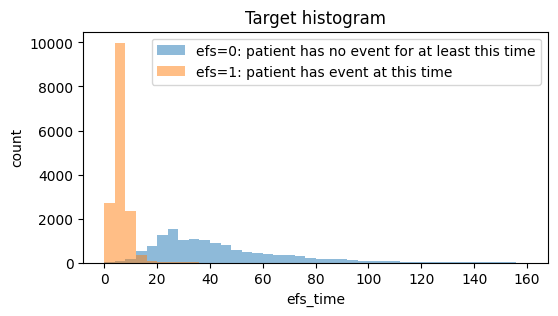

In [11]:
plt.figure(figsize=(6, 3))
plt.hist(train.efs_time[train.efs == 0], bins=np.linspace(0, 160, 41), label='efs=0: patient has no event for at least this time', alpha=0.5)
plt.hist(train.efs_time[train.efs == 1], bins=np.linspace(0, 160, 41), label='efs=1: patient has event at this time', alpha=0.5)
plt.legend()
plt.xlabel('efs_time')
plt.ylabel('count')
plt.title('Target histogram')
plt.show()

### Missing values
Because we are dealing with medical data, in order to protect patient privacy, some data is censored.  
Oftentimes, medical data can also be incomplete due to not being measured for all cases.

Both of these things can contribute to missing values in the dataset, that we will have to deal with during our research.  
First, we will find out which features have missing values.

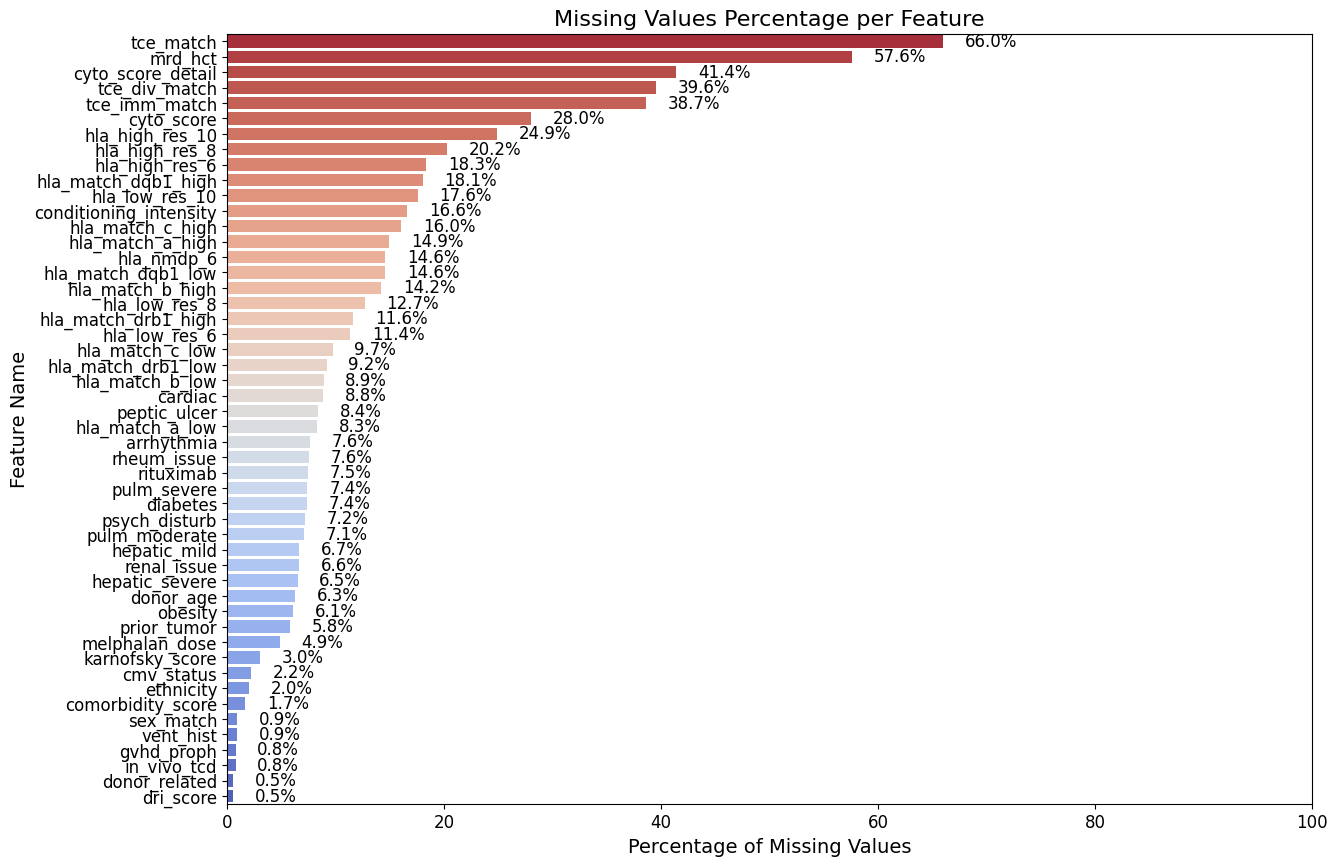

In [12]:
# Calculate missing values percentage
missing_values = train.isnull().sum() / len(train) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Generate a color gradient from dark blue (low missing) to red (high missing)
colors = sns.color_palette("coolwarm", len(missing_values))[::-1]

# Plot missing values with updated formatting
plt.figure(figsize=(14, 10))
bars = sns.barplot(y=missing_values.index, x=missing_values.values, palette=colors, hue=missing_values.index)

# Set x-axis to always go up to 100%
plt.xlim(0, 100)

# Labels and title
plt.xlabel("Percentage of Missing Values", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.title("Missing Values Percentage per Feature", fontsize=16)

# Rotate x-axis ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

# Annotate each bar with its missing percentage
for bar, value in zip(bars.patches, missing_values.values):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}%", ha='left', va='center', fontsize=12, color='black')

plt.show()

As we can see, a significant amount of features contain missing data.  
With 2 (`tce_match` and `mrd_hct`) containing more than 50% missing values!

We have three options:
1. Fill in (impute) the missing values using the mean, median, or mode.
2. Drop the feature if it’s mostly empty.
3. Treat missing values as a separate category - sometimes missing data itself carries meaning!

We have decided to remove `tce_match` and `mrd_hct` from our data.
For the rest of the categorical features, we choose the third option.

In [13]:
train = train.drop(columns=['tce_match', 'mrd_hct'], errors='ignore')

categorical_cols = train.select_dtypes(exclude=['number']).columns
features = categorical_cols.to_list() + numerical_cols.to_list()

train[categorical_cols] = train[categorical_cols].astype(str).astype('category')

Let's review the missing values now.

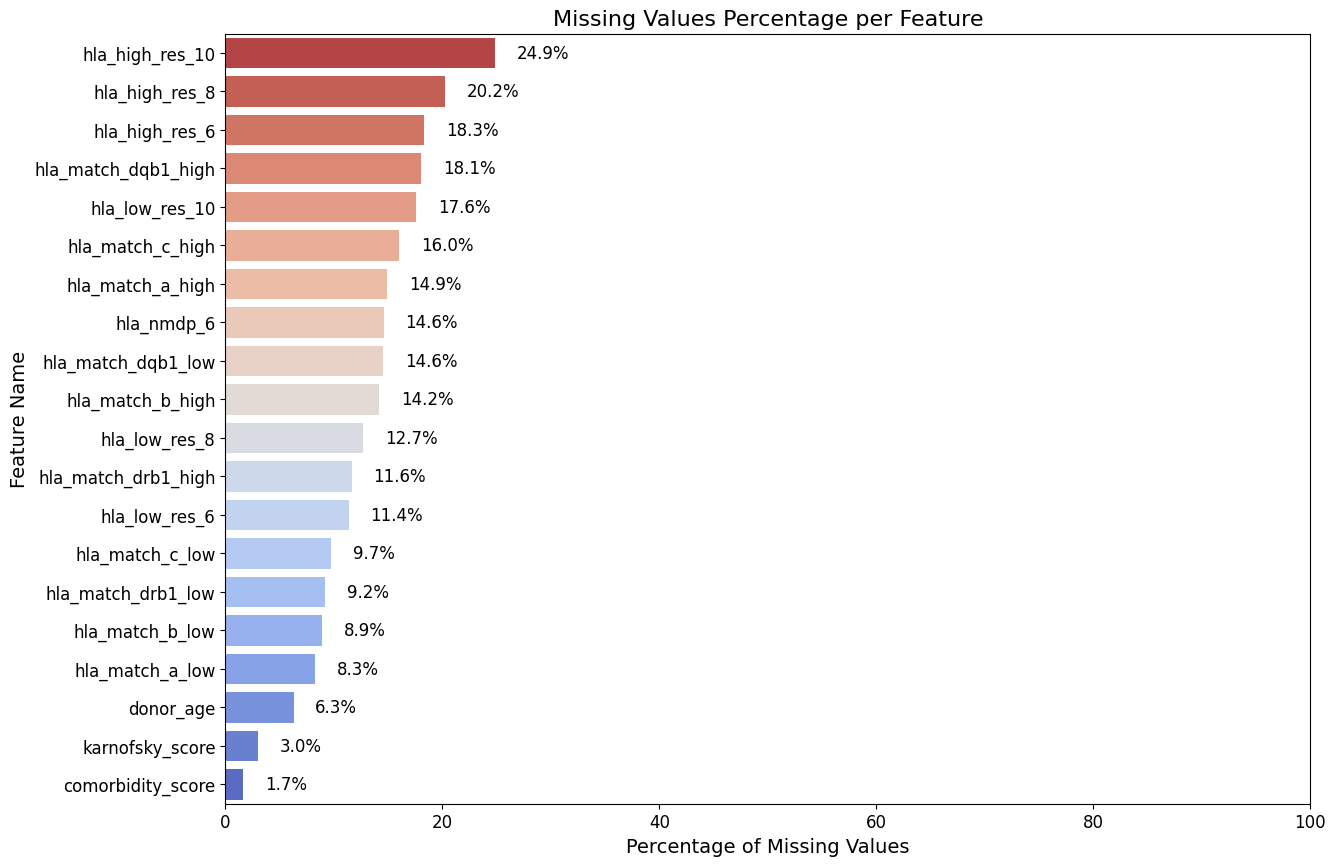

In [14]:
# Calculate missing values percentage
missing_values = train.isnull().sum() / len(train) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Generate a color gradient from dark blue (low missing) to red (high missing)
colors = sns.color_palette("coolwarm", len(missing_values))[::-1]

# Plot missing values with updated formatting
plt.figure(figsize=(14, 10))
bars = sns.barplot(y=missing_values.index, x=missing_values.values, palette=colors, hue=missing_values.index)

# Set x-axis to always go up to 100%
plt.xlim(0, 100)

# Labels and title
plt.xlabel("Percentage of Missing Values", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.title("Missing Values Percentage per Feature", fontsize=16)

# Rotate x-axis ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

# Annotate each bar with its missing percentage
for bar, value in zip(bars.patches, missing_values.values):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}%", ha='left', va='center', fontsize=12, color='black')

plt.show()

Much better!  
Now our models will be able to handle missing values for categorical features.

We still have many numerical HLA features that have a good amount of missing values.  
For now we won't touch them, as they seem suspicious and we are not sure if and how we will change them after further reviewing them.

### Synthetic data artifacts

As pointed out in the problem description, the data used in the training dataset is synthetic, in order to "*mirror real-world situations while protecting patient privacy*".  
This is with the goal to help us "*build and improve models that more effectively consider diverse backgrounds and conditions*".

But as we will see, the data has some clear data generation artifacts, that prevent it from actually mirroring real-world situations.


##### Race group distribution
In the training data, there are six race groups with about 4800 samples each.  
Because in no country of the world these six race groups occur with equal frequencies, we know that some of the groups have been upsampled or downsampled in the dataset.

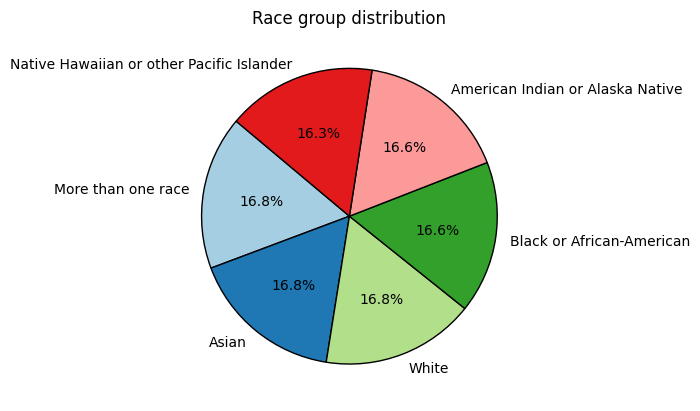

In [15]:
race_counts = train.race_group.value_counts()

plt.pie(race_counts.values, labels=race_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'})

plt.title('Race group distribution')
plt.show()

We can change the race distribution in the dataset to fit real world distributions by removing or duplicating samples.  
But due to the dataset being rather small, we don't have enough data points to do so without majorly affecting the results.  
That is why we have decided not to do that for now.

##### Patient age distribution
There are only two features with continuous data: donor age and patient age.  
The patient age histogram shows that the patient age distribution has five modes.  
Such a distribution is highly unnatural, it must be an artifact of the synthetic data generation. 

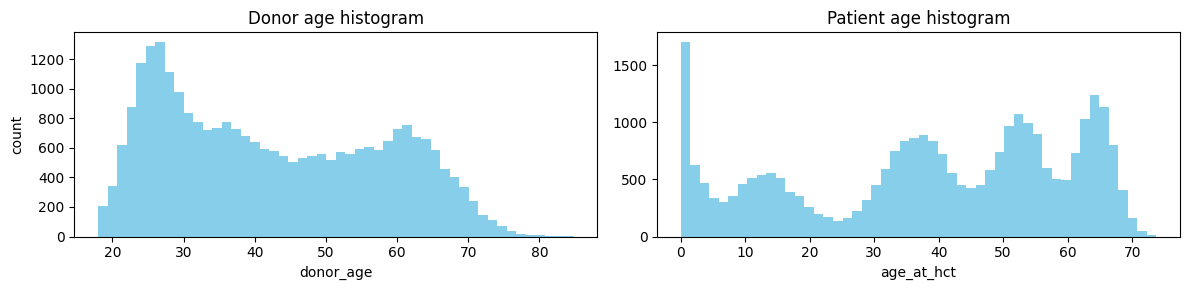

In [16]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.hist(train.donor_age, bins=50, color='skyblue')
plt.title('Donor age histogram')
plt.xlabel('donor_age')
plt.ylabel('count')
plt.subplot(1, 2, 2)
plt.title('Patient age histogram')
plt.hist(train.age_at_hct, bins=50, color='skyblue')
plt.xlabel('age_at_hct')
plt.tight_layout()
plt.show()

Our first thought was that different race groups had different modes, but the patient age distribution has the same five modes in every race group:

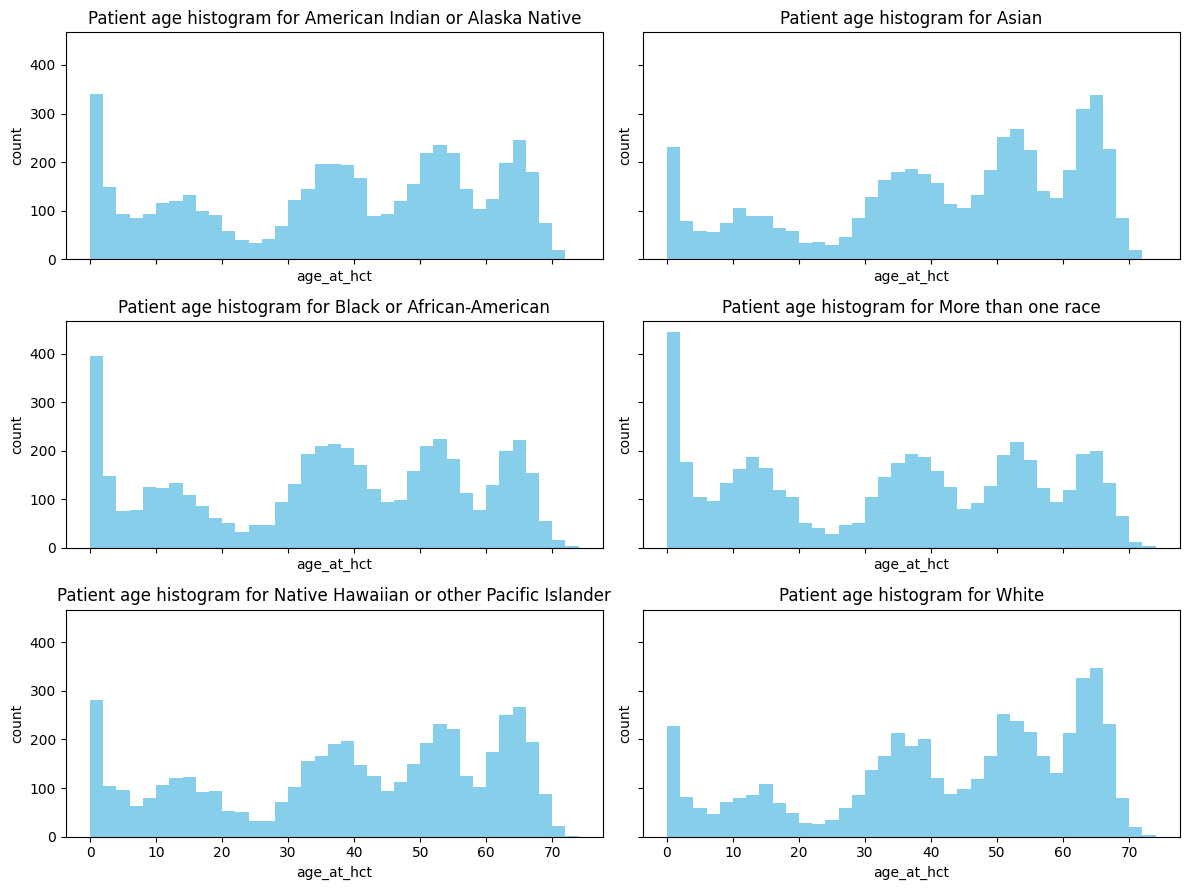

In [17]:
_, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 9))
for race_group, ax in zip(race_groups, axs.ravel()):
    ax.hist(train.age_at_hct[train.race_group == race_group],
            bins=np.linspace(0, 74, 38),
            color='skyblue')
    ax.set_title(f'Patient age histogram for {race_group}')
    ax.set_xlabel('age_at_hct')
    ax.set_ylabel('count')
plt.tight_layout()
plt.show()

Even stranger, The age of 0.044 years (i.e., 16 days) occurs 1005 times in the training dataset, whereas every other age occurs at most six times.  
Is hematopoietic cell transplantation a treatment which is often done to newborns? Possible. But we can't believe that these babies are all treated exactly when they are 16 days old. 

Text(0.044, 949.725, 'Age 0.044: 1005 occurrences')

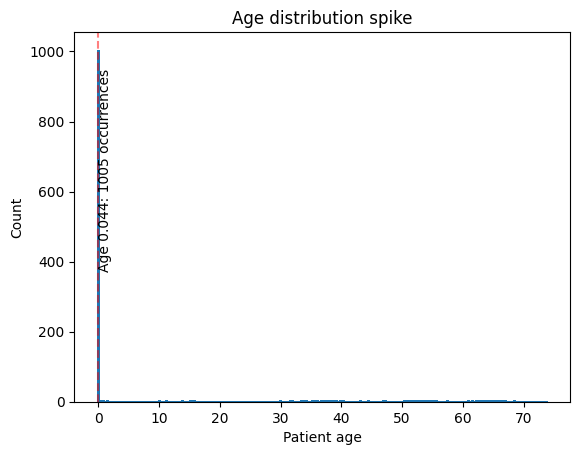

In [18]:
age_counts = pd.Series(train.age_at_hct.round(3).value_counts().sort_index())
plt.bar(age_counts.index, age_counts.values, width=0.5)
plt.title('Age distribution spike')
plt.xlabel('Patient age')
plt.ylabel('Count')

# Highlight the suspicious spike at age 0.044
plt.axvline(x=0.044, color='red', linestyle='--', alpha=0.5)
plt.text(0.044, plt.ylim()[1]*0.9,
         f'Age 0.044: {train.age_at_hct.value_counts().get(0.044, 0)} occurrences',
         rotation=90, verticalalignment='top')

As much as we would like to use the patient age in our predictions, as it would make sense for it to affect the prediction target.  
Its distribution doesn't make sense, and not worth keeping.  
Therefore, we have decided to drop this feature from our data.

In [19]:
train = train.drop(columns=['age_at_hct'], errors='ignore')

numerical_cols = train.select_dtypes(include=['number']).columns.drop(['efs', 'efs_time'])
features = categorical_cols.to_list() + numerical_cols.to_list()

##### HLA matching scores
There is high correlation between different HLA measures.  
Such high correlation is more than we expected.  
This might suggest that there are redundant synthetic features in the data.

Text(0.5, 1.0, 'HLA matching scores correlation\n(Potential duplicated information)')

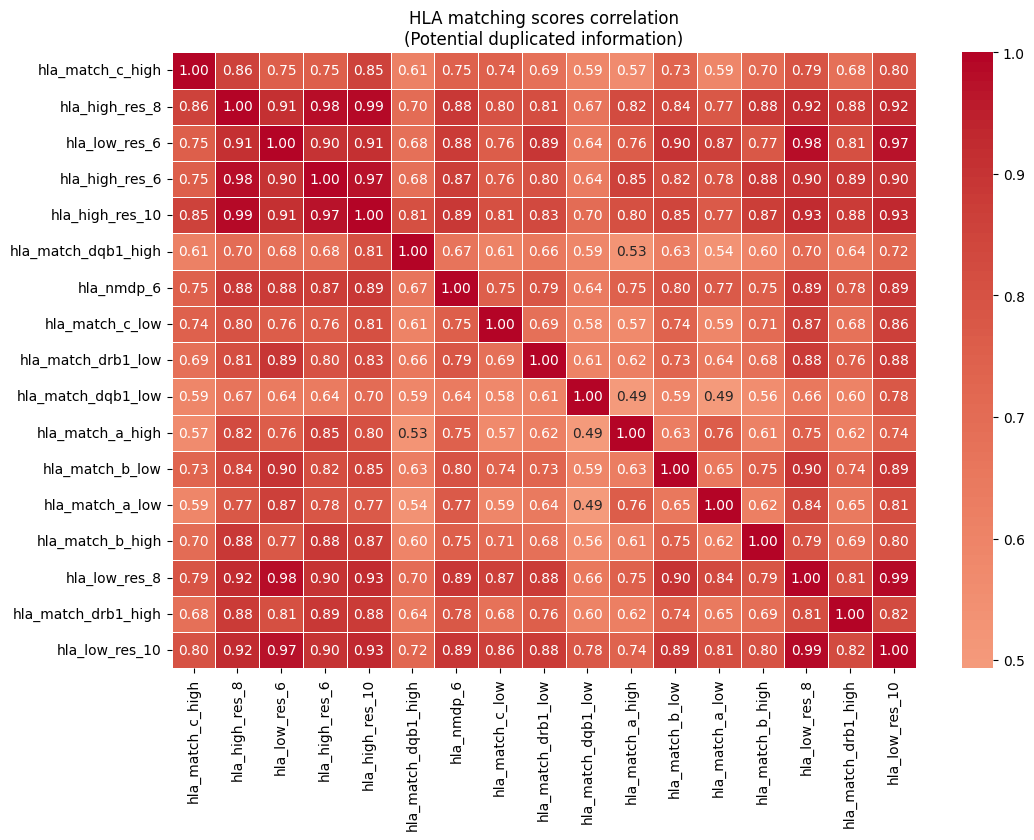

In [20]:
hla_cols = [col for col in train.columns if 'hla' in col]
hla_corr = train[hla_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(hla_corr, cmap="coolwarm", linewidths=0.5, center=0, annot=True, fmt=".2f")
plt.title('HLA matching scores correlation\n(Potential duplicated information)')

Even if this high correlation is prevalent in real world cases, it still points out that some of these features are redundant.  
Before doing something about this, let's understand the meaning of these features.  

**Transplant and treatment information:**  
- `hla_match_c_high` / `hla_match_c_low`: These columns describe the compatibility of certain Human Leukocyte Antigen (HLA) markers on the donor and recipient.  
    High/low might indicate how well they match.
- `hla_high_res_8` / `hla_high_res_6` / `hla_high_res_10`: These columns refer to the resolution level of the HLA match between the donor and recipient for specific HLA markers.  
    Higher resolution means a more detailed matching process.
- `hla_low_res_6` / `hla_low_res_8` / `hla_low_res_10`: Similar to the previous columns but refer to lower resolution matches for the same HLA markers.

**HLA matching:**  
- `hla_match_a_high` / `hla_match_b_high` / `hla_match_drb1_high`: These columns refer to the compatibility of specific HLA genes (A, B, DRB1) between the donor and recipient.  
    High indicates a better match.
- `hla_match_a_low` / `hla_match_b_low` / `hla_match_drb1_low`: Similar to the above columns but represent low-level matches for these specific HLA genes.
- `hla_match_dqb1_high` / `hla_match_dqb1_low`: Specific matching information for another HLA gene, DQB1.

If we look at their values, we find that they are integers that have various ranges but all fall between 0 and 10.  
And that for all of them, a higher value is better.  
So if we combine some of them them, summarizing might be a good solution.

In [21]:
hla_ranges = train[hla_cols].agg(['min', 'max'])
display(hla_ranges)

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,hla_match_a_high,hla_match_b_low,hla_match_a_low,hla_match_b_high,hla_low_res_8,hla_match_drb1_high,hla_low_res_10
min,0.0,2.0,2.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0
max,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0


We have decided on a `0.75` threshold for correlation, and will combine all group that have such correlation.

In [22]:
corr_num = 0.75
corr = hla_corr[(hla_corr >= corr_num) & (hla_corr < 1)]

high_corr_pairs = []
for i, j in itertools.combinations(hla_corr.columns, 2):
    corr_value = hla_corr.loc[i, j]
    if corr_num <= corr_value < 1:
        high_corr_pairs.append((i, j, corr_value))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Load the correlation pairs as a DataFrame
pairs = list(zip(high_corr_df['Feature 1'], high_corr_df['Feature 2']))

# Build graph to group correlated features into clusters
G = nx.Graph()
G.add_edges_from(pairs)
groups = list(nx.connected_components(G))

print(f'Group count: {len(groups)}')
print(f'Group size: {len(groups[0])}')
print(f'Hla feature count: {len(hla_cols)}')

Group count: 1
Group size: 17
Hla feature count: 17


It seems all HLA features have at least one correlation to another HLA feature with a value of `0.75` or more.  
Therefore, we will summarize all HLA features into one and replace all of them with the new feature.  
For missing values in each feature, we will use 0 to not affect the sum.

In [23]:
hla_filled = train[hla_cols].fillna(0)
train['hla'] = hla_filled.sum(axis=1)
train = train.drop(columns=hla_cols, errors='ignore')

numerical_cols = train.select_dtypes(include=['number']).columns.drop(['efs', 'efs_time'])
features = categorical_cols.to_list() + numerical_cols.to_list()

### Feature correlation
As we saw in the previous section, there was a high correlation between all HLA features (and we combined them to one feature).  
It is important to see if we can find some correlation between other features.  

Let's explore the relationships between numerical features.

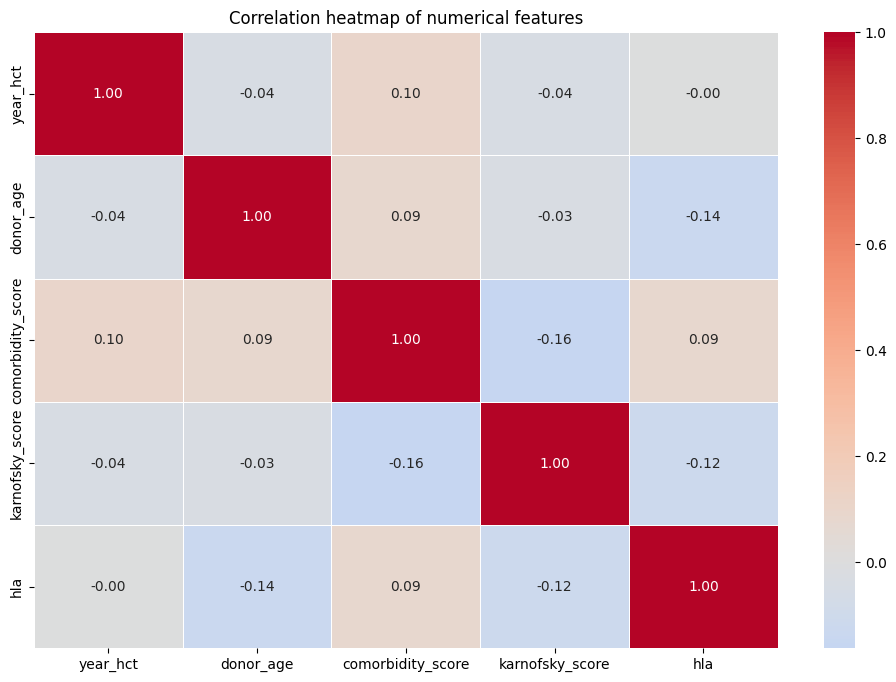

In [24]:
plt.figure(figsize=(12, 8))
corr_matrix = train[numerical_cols].corr(numeric_only=True) # Only numerical columns
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5, center=0, annot=True, fmt=".2f")
plt.title("Correlation heatmap of numerical features")
plt.show()

As we can see there isn't a high correlation between our numerical features, so we won't change them further.

### Survival time by race

The survival function shows how many patients have no event for an amount of time ([Kaplan–Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator)).  
At month 0, 100% of the patients have no event. At month 20, only 40% - 60% remain without event, depending on their race group.  

The cumulative hazard is another representation of the same facts, it corresponds to the negative logarithm of the survival function ([Nelson–Aalen estimator](https://en.wikipedia.org/wiki/Nelson%E2%80%93Aalen_estimator)).

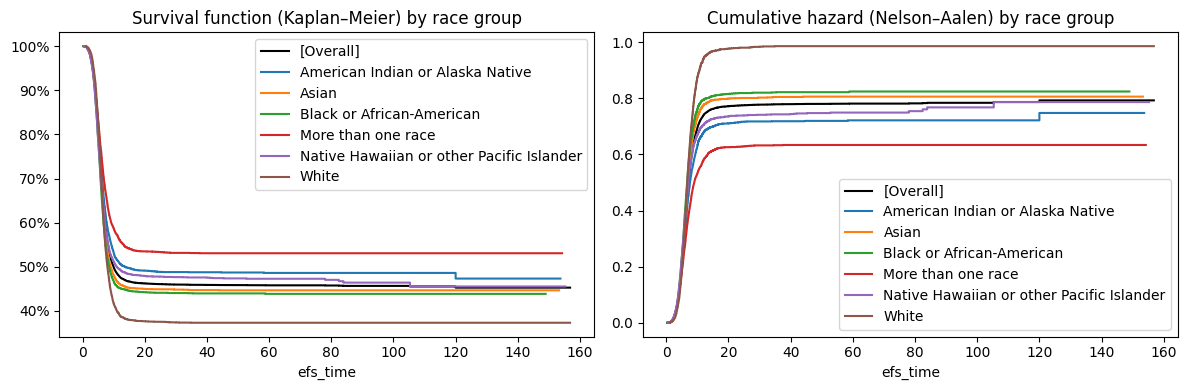

In [25]:
def survival_function(df):
    survival_df = df[['efs', 'efs_time']].groupby('efs_time').agg(['size', 'sum']).droplevel(0, axis=1).astype(int)
    survival_df['n_at_risk'] = survival_df['size'].sum() - survival_df['size'].shift().fillna(0).cumsum().astype(int)
    hazard = survival_df['sum'] / survival_df['n_at_risk'] 
    survival_df['cumulative_hazard'] = np.cumsum(hazard) # nelson_aalen_estimator
    survival_df['survival_probability'] = (1 - hazard).cumprod() # kaplan_meier_estimator
    return survival_df

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
survival_df = survival_function(train)
plt.step(survival_df.index, survival_df['survival_probability'], c='k', where="post", label='[Overall]')
plt.xlabel('efs_time')
for race_group in race_groups:
    subset = train.query('race_group == @race_group')
    survival_df = survival_function(subset)
    plt.step(survival_df.index, survival_df['survival_probability'], where="post", label=race_group)
plt.xlabel('efs_time')
plt.legend(loc='upper right')
plt.title('Survival function (Kaplan–Meier) by race group')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0)) # percent of xmax

plt.subplot(1, 2, 2)
survival_df = survival_function(train)
plt.step(survival_df.index, survival_df['cumulative_hazard'], c='k', where="post", label='[Overall]')
plt.xlabel('efs_time')
for race_group in race_groups:
    subset = train.query('race_group == @race_group')
    survival_df = survival_function(subset)
    plt.step(survival_df.index, survival_df['cumulative_hazard'], where="post", label=race_group)
plt.xlabel('efs_time')
plt.legend(loc='lower right')
plt.title('Cumulative hazard (Nelson–Aalen) by race group')

plt.tight_layout()
plt.show()

While most race groups have similar survival times,  
it is intresting to see that patients with **"more than one race"** have the highest probability of event-free survival, with some gap.  
On the other side, **white** patients have the lowest probability of event-free survival, with an even more significant gap.  

This might be explained by mixed people having better genes, that make them healthier and more likely to have an event free survival.  
It might also mean that white people are genetically more inclined to suffer from an event after HCT.

### The significance of the race group
As we saw, the survival time differs significantly between the race groups in the dataset.  
Our goal is to develop accurate and fair survival models across diverse race groups.  
Do other features have significant differences across race groups?  
Let's find out with Chi-square tests for categorical features and Kruskal-Wallis for numerical:  

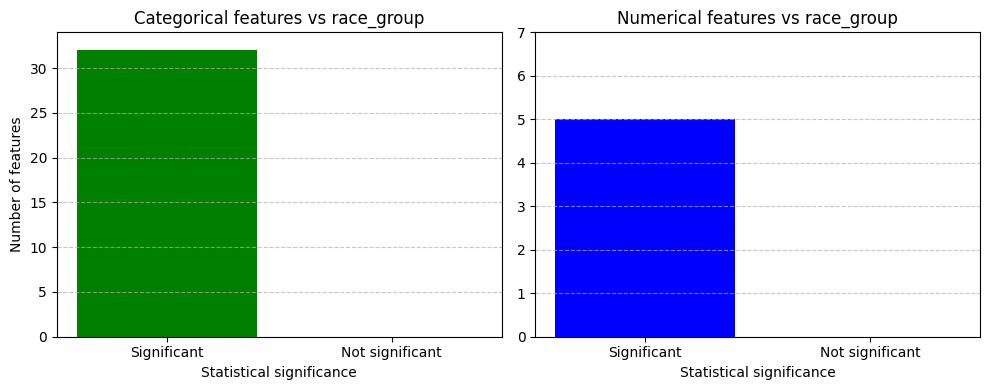

In [26]:
cat_cols = categorical_cols.drop('race_group')

# Significance results tracking
cat_significance = {'Significant': 0, 'Not significant': 0}
num_significance = {'Significant': 0, 'Not significant': 0}

# Chi-square for categorical features
for var in cat_cols:
    contingency = pd.crosstab(train['race_group'], train[var])
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    if p_val < 0.05:
        cat_significance['Significant'] += 1
    else:
        cat_significance['Not significant'] += 1

# Kruskal-Wallis for numerical features
for var in numerical_cols:
    groups = [group[var].dropna() for name, group in train.groupby('race_group', observed=True)]
    stat, p_val = kruskal(*groups)
    if p_val < 0.05:
        num_significance['Significant'] += 1
    else:
        num_significance['Not significant'] += 1

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].bar(cat_significance.keys(), cat_significance.values(), color=['green', 'gray'])
axs[0].set_title('Categorical features vs race_group')
axs[0].set_ylabel('Number of features')
axs[0].set_ylim(0, max(cat_significance.values()) + 2)

axs[1].bar(num_significance.keys(), num_significance.values(), color=['blue', 'gray'])
axs[1].set_title('Numerical features vs race_group')
axs[1].set_ylim(0, max(num_significance.values()) + 2)

for ax in axs:
    ax.set_xlabel('Statistical significance')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

It seems all features in the dataset have a statistically significant difference across different race groups!  
This means that:
- For categorical features: the distributions of categories differ by race group.
- For numerical features: the distributions or medians differ across race groups.

Because of this correlation, our model’s performance must be assessed across race groups, which is a given in this challenge.

This discovery—that every feature differs by race—is not a flaw; it's a signal that systemic differences exist in the synthetic dataset (and by extension, in real-world data).  
This opens the door to:  
- Highlighting unfairness in predictive systems.
- Building models that don’t just predict well, but do so equitably.

# Evaluation

This competition emphasizes fairness — models should perform well **across all race groups**, not just on average.  
The official scoring metric is based on the **concordance index (C-index) stratified by race group** (the mean of all race groups - the standard deviation = the model score),  
but it does not report performance per group.  
For transperancy, in our evaluation functions we display the results per group as well (though without the standard deviation subtraction).  

We also wanted to have other evaluation metrics, but due to the unique characteristics of the predicted data and this being a survival analysis problem,  
the only other proper method we have found is the **Time-dependent AUC (t-AUC)**, which measures the model's **discriminative ability** at a specific time point *t*.  
It tells us how well the model distinguishes between individuals who experience the event **before or at time** *t* vs. those who **don't experience an event beyond** *t*.  
Like the C-index, we stratify this metric by the race group.

In [27]:
all_tests = { 'scores': {}, 'aucs': {} }
all_model_data = {'scores': {}, 'aucs': {}, 'models': {}, 'times': {}}
time_points = np.arange(6, 12 * 5 + 1, 6)  # years 0.5 to 5 in half months

def humanize_time(time_in_seconds):
    return humanize.precisedelta(datetime.timedelta(seconds=time_in_seconds))

In [28]:
def evaluate(y_va_pred, X_va, idx_va):
    """Evaluate one fold and return per-race c-index and time-dependent AUCs."""
    c_indexes = {}
    aucs_by_time = {t: {} for t in time_points}

    for race in race_groups:
        mask = X_va.race_group.values == race
        durations = train.efs_time.iloc[idx_va][mask].values
        events = train.efs.iloc[idx_va][mask].values
        surv_val = Surv.from_arrays(events == 1, durations)

        durations_train = train.efs_time.iloc[idx_va][~mask].values
        events_train = train.efs.iloc[idx_va][~mask].values
        surv_train = Surv.from_arrays(events_train == 1, durations_train)

        c_index = concordance_index(durations, -y_va_pred[mask], events)
        c_indexes[race] = c_index

        for t in time_points:
            # Check if t lies within the follow-up window
            if durations.min() < t < durations.max():
                auc, _ = cumulative_dynamic_auc(surv_train, surv_val, y_va_pred[mask], times=[t])
                aucs_by_time[t][race] = auc[0]
            else:
                aucs_by_time[t][race] = np.nan  # Or skip saving this time point

    return {'c_indexes': c_indexes, 'aucs': aucs_by_time}

At the end of this notebook we will run our models on a test set not used for training.  
Currently our test set containes only 3 rows and we don't know their target values (`efs` and `efs_time`).  
Sadly we can't download the real test set, it can only be used during submission of a notebook to the competition.  

To solve this, we take 300 rows from the train dataset, that we will use only for a final evaluation.  
To not change the train dataset's race distribiution and to ensure appearance of all groups in the test dataset, we will sample an equal amount of from each.

To allow further transformations of the train set, and to give good use to our `evaluation` function,  
we will only save the test indices and ignore them during the training (but keep them in `train`).  

In [29]:
# Sample test data
samples_per_group = 300 // len(race_groups)

# Reserve test indices without removing data
test_indices = pd.concat([
    train[train['race_group'] == group].sample(n=samples_per_group, random_state=RANDOM_SEED)
    for group in race_groups
]).index
train_indices = train.index.difference(test_indices)

We use **5-fold cross-validation** to evaluate our models, and display the scores per fold for each model.  
For each CV run, we additionaly measure the runtime of the entire CV and save each fitted model per fold.

To make model evaluation easier, we also created a function that would run cross-validation for a model, evaluate per fold and display overall performance.  
This is something we will do for each model.  

In [30]:
def aggregate_cv_results(all_fold_results):
    """Aggregate per-fold metrics into final tables"""
    # Concordance Index
    scores_df = pd.DataFrame([fold['c_indexes'] for fold in all_fold_results])
    scores_df['mean'] = scores_df.mean(axis=1)
    scores_df['std'] = scores_df[race_groups].std(axis=1)
    scores_df['score'] = scores_df['mean'] - scores_df['std']
    scores_df = scores_df.T
    scores_df.columns = [f"Fold {i}" for i in range(1, scores_df.shape[1] + 1)]
    scores_df['Overall'] = scores_df.mean(axis=1)

    # AUCs
    aucs = {}
    aucs_by_fold = {
        t: pd.DataFrame([fold['aucs'][t] for fold in all_fold_results]) for t in time_points
    }

    for time, fold_auc_scores in aucs_by_fold.items():
        mean_per_fold = fold_auc_scores.mean(axis=1)
        std_per_fold = fold_auc_scores[race_groups].std(axis=1)
        score_per_fold = mean_per_fold - std_per_fold
        aucs[time] = score_per_fold.mean()

    return scores_df, aucs

In [31]:
def display_cv_results(scores, model_name):
    """Visualize metrics and store in global results."""
    print(f"# Overall score for {model_name}: {scores.loc['score', 'Overall']:.3f}")
    temp = scores.drop(index=['std']).values

    display(
        scores.iloc[:len(race_groups)]
        .style
        .format(precision=3)
        .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
        .concat(scores.iloc[len(race_groups):].style.format(precision=3))
    )

In [32]:
kf = StratifiedKFold(n_splits=5 ,shuffle=True, random_state=RANDOM_SEED)

def evaluate_model_cv(model_name, model_fn, display_results=True):
    """Cross-validate model, compute per-group metrics, save models and evaluation summary."""
    start_time = time.time()
    all_fold_results = []

    for fold, (idx_tr, idx_va) in enumerate(kf.split(train.loc[train_indices], train.loc[train_indices, 'race_group'])):
        idx_tr = train_indices[idx_tr]
        idx_va = train_indices[idx_va]

        model, y_va_pred, X_va = model_fn(idx_tr, idx_va)
        fold_metrics = evaluate(y_va_pred, X_va, idx_va)
        all_fold_results.append(fold_metrics)

        all_model_data['models'].setdefault(model_name, {})[fold] = model

    end_time = time.time()
    all_model_data['times'][model_name] = end_time - start_time
    print(f"# Total time for {model_name}: {humanize_time(end_time - start_time)}")

    scores, aucs = aggregate_cv_results(all_fold_results)
    all_model_data['scores'][model_name] = scores.loc['score', 'Overall']
    all_model_data['aucs'][model_name] = aucs

    if display_results:
        display_cv_results(scores, model_name)

In [33]:
def evaluate_model_testset(model_name, model_fn):
    """Train on train_indices, evaluate on test_indices, and store results in all_tests."""
    start_time = time.time()

    # Train the model using the full train_indices and test on test_indices
    _, y_va_pred, X_va = model_fn(train_indices, test_indices)
    test_metrics = evaluate(y_va_pred, X_va, test_indices)

    scores, aucs = aggregate_cv_results([test_metrics])

    # Save results to all_tests
    all_tests['scores'][model_name] = scores.loc['score', 'Overall']
    all_tests['aucs'][model_name] = aucs
    print(f"# Test evaluation completed for {model_name}: {humanize_time(time.time() - start_time)}")

# First basic models
To establish a robust baseline and assess the effectiveness of various modeling approaches,  
we begin by exploring several foundational models.

Our selection includes:
- `lifelines`: A dedicated survival analysis library offering classical models like Cox Proportional Hazards, providing a statistical baseline.

- `XGBoost`: A versatile gradient boosting framework that supports survival analysis through both the Cox Proportional Hazards model and the Accelerated Failure Time (AFT) model. This flexibility allows us to model different aspects of survival data effectively.

- `CatBoost`: While not specifically designed for survival analysis, CatBoost's robust handling of categorical variables and strong performance in regression tasks make it a valuable candidate. By adapting its regression capabilities, we can approximate survival models, enabling us to leverage its strengths in handling complex datasets.

By evaluating models from these libraries, we aim to identify approaches that balance predictive accuracy with computational efficiency, providing a comprehensive understanding of their applicability to survival analysis tasks.

For all gradient boosting models (`XGBoost` and `CatBoost`), we initially adopted hyperparameter settings from external examples and commonly recommended configurations.  
These parameters were chosen to provide strong, practical starting points, without dataset-specific tuning at this stage.  

### Cox proportional hazards - linear model
One classical approach to survival analysis is the [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model).  
It models the hazard function, which describes the instantaneous risk of an event occurring at a given time, conditioned on covariates.  
A fundamental assumption of the Cox model is proportional hazards — the hazard ratio between two individuals is assumed to remain constant over time.  

There are multiple ways to implement the Cox model, and different implementations can produce slightly different results.  
As a starting point, we use a **linear Cox proportional hazards model**, implemented with `CoxPHFitter` from the `lifelines` library.  
This version requires **one-hot encoding** for categorical features and imputation for missing values.

The model expects a DataFrame with `time` and `event` columns, corresponding to the survival time and the event indicator.  

In [34]:
def linear_cox(idx_tr, idx_va):
    preproc = ColumnTransformer([
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
    ],
    remainder=SimpleImputer(strategy='median'),
    verbose_feature_names_out=False
    ).set_output(transform='pandas')
    
    X_tr = preproc.fit_transform(train.iloc[idx_tr])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X_va = preproc.transform(train.iloc[idx_va])
    
    model = CoxPHFitter(penalizer=0.01)
    feats = [f for f in X_tr.columns if f not in ['gvhd_proph_FK+- others(not MMF,MTX)']]
    model.fit(X_tr[feats], duration_col='efs_time', event_col='efs')
    
    X_va['race_group'] = train.race_group.iloc[idx_va]
    y_va_pred = model.predict_partial_hazard(X_va[feats])
    
    return model, y_va_pred, X_va

evaluate_model_cv('Cox Proportional Hazards Linear', linear_cox)

# Total time for Cox Proportional Hazards Linear: 49.67 seconds
# Overall score for Cox Proportional Hazards Linear: 0.650


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.670,0.683,0.672,0.669,0.676,0.674
Asian,0.688,0.670,0.686,0.680,0.678,0.680
Black or African-American,0.658,0.654,0.681,0.658,0.644,0.659
More than one race,0.664,0.675,0.656,0.687,0.693,0.675
Native Hawaiian or other Pacific Islander,0.674,0.655,0.664,0.668,0.650,0.662
White,0.660,0.638,0.646,0.640,0.645,0.646
mean,0.669,0.663,0.668,0.667,0.664,0.666
std,0.011,0.017,0.015,0.017,0.021,0.016
score,0.658,0.646,0.652,0.650,0.643,0.650


### Cox proportional hazards - XGBoost
Beyond classical statistical implementations, gradient boosting libraries such as `XGBoost` also support survival analysis.  
`XGBoost` includes a built-in objective for the **Cox Proportional Hazards model** (`survival:cox`), enabling efficient modeling of censored survival data using decision trees.

In the `XGBoost` implementation, the time and event information must be combined into a single target variable:
- **Observed events**: `y = efs_time`
- **Censored observations**: `y = -efs_time`

That is, negative survival times indicate right-censored data.

In [35]:
def cox_xgboost(idx_tr, idx_va):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y = np.where(train.efs == 1, train.efs_time, -train.efs_time)
    y_tr = y[idx_tr]
    
    xgb_cox_params = {
        'objective': 'survival:cox',
        'grow_policy': 'depthwise',
        'n_estimators': 700,
        'learning_rate': 0.0254,
        'max_depth': 8,
        'reg_lambda': 0.116,
        'reg_alpha': 0.139,
        'min_child_weight': 37.8,
        'colsample_bytree': 0.59,
        'subsample': 0.7,
        'tree_method': 'hist',
        'enable_categorical': True,
        'random_state': RANDOM_SEED
    }
    
    model = xgboost.XGBRegressor(**xgb_cox_params)
    model.fit(X_tr, y_tr)  # negative targets are treated as censored
    y_va_pred = model.predict(X_va)  # predicts hazard function values
    
    return model, y_va_pred, X_va

evaluate_model_cv('Cox Proportional Hazards XGBoost', cox_xgboost)

# Total time for Cox Proportional Hazards XGBoost: 15.25 seconds
# Overall score for Cox Proportional Hazards XGBoost: 0.663


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.678,0.700,0.682,0.694,0.678,0.686
Asian,0.704,0.677,0.686,0.693,0.686,0.689
Black or African-American,0.672,0.664,0.689,0.670,0.653,0.669
More than one race,0.678,0.688,0.666,0.688,0.708,0.686
Native Hawaiian or other Pacific Islander,0.670,0.667,0.671,0.676,0.656,0.668
White,0.678,0.656,0.663,0.665,0.672,0.667
mean,0.680,0.675,0.676,0.681,0.676,0.678
std,0.012,0.016,0.011,0.013,0.021,0.015
score,0.668,0.659,0.665,0.668,0.655,0.663


### Cox proportional hazards - CatBoost
We also explore `CatBoost`'s support for survival analysis.  
`CatBoost` provides a dedicated `Cox` loss function for modeling the hazard function, similarly to `XGBoost`.
As with the `XGBoost` Cox model, the targets must combine survival time and censoring information:
- **Observed events**: `y = efs_time`
- **Censored observations**: `y = -efs_time`

This structure allows the model to handle censored data natively.

In [36]:
def cox_catboost(idx_tr, idx_va):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y = np.where(train.efs == 1, train.efs_time, -train.efs_time)
    y_tr = y[idx_tr]

    cb_cox_params = {
        'loss_function': 'Cox',
        'grow_policy': 'SymmetricTree',
        'n_estimators': 800,
        'learning_rate': 0.092,
        'l2_leaf_reg': 2.5,
        'max_depth': 6,
        'colsample_bylevel': 0.84,
        'subsample': 0.8,
        'random_strength': 0.8,
        'verbose': False,
        'random_state': RANDOM_SEED
    }
    
    model = catboost.CatBoostRegressor(**cb_cox_params, cat_features=list(categorical_cols))
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)  # predicts log hazard function values
    
    return model, y_va_pred, X_va

evaluate_model_cv('Cox Proportional Hazards CatBoost', cox_catboost)

# Total time for Cox Proportional Hazards CatBoost: 2 minutes and 8.06 seconds
# Overall score for Cox Proportional Hazards CatBoost: 0.663


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.683,0.695,0.685,0.690,0.682,0.687
Asian,0.700,0.682,0.689,0.690,0.683,0.689
Black or African-American,0.667,0.662,0.688,0.674,0.656,0.669
More than one race,0.678,0.685,0.665,0.687,0.706,0.684
Native Hawaiian or other Pacific Islander,0.675,0.666,0.675,0.679,0.660,0.671
White,0.673,0.654,0.661,0.660,0.668,0.663
mean,0.679,0.674,0.677,0.680,0.676,0.677
std,0.011,0.016,0.012,0.012,0.019,0.014
score,0.668,0.658,0.665,0.668,0.657,0.663


### Accelerated failure time - XGBoost
Another major approach to survival analysis is the [Accelerated failure time (AFT) model](https://en.wikipedia.org/wiki/Accelerated_failure_time_model).  
Unlike the Cox model, which models hazard ratios, the AFT model directly predicts the event time, assuming that covariates accelerate or decelerate survival time by a constant factor.  

We first explore the AFT model implemented in `XGBoost`.  
In this setup, the model expects both lower and upper bounds for the event time, enabling it to handle censored data correctly.  

In [37]:
def aft_xgboost(idx_tr, idx_va):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    
    d_tr = xgboost.DMatrix(X_tr, enable_categorical=True)
    d_tr.set_float_info('label_lower_bound', train.efs_time.iloc[idx_tr])
    d_tr.set_float_info('label_upper_bound', np.where(train.efs.iloc[idx_tr] == 0, np.inf, train.efs_time.iloc[idx_tr]))
    
    d_va = xgboost.DMatrix(X_va, enable_categorical=True)
    d_va.set_float_info('label_lower_bound', train.efs_time.iloc[idx_va])
    d_va.set_float_info('label_upper_bound', np.where(train.efs.iloc[idx_va] == 0, np.inf, train.efs_time.iloc[idx_va]))
    
    xgboost_aft_params = {
        'objective': 'survival:aft',
        'aft_loss_distribution': 'normal',
        'aft_loss_distribution_scale': 0.9,
        'learning_rate': 0.08,
        'max_depth': 4,
        'reg_lambda': 3,
        'reg_alpha': 0.24,
        'gamma': 0.033,
        'min_child_weight': 82.5886,
        'colsample_bytree': 0.5662,
        'subsample': 0.7456,
        'max_bin': 53,
        'grow_policy': 'depthwise',
        'tree_method': 'hist',
    }
    
    model = xgboost.train(xgboost_aft_params, d_tr, num_boost_round=300)
    y_va_pred = -model.predict(d_va)  # model predicts time-to-event estimates
    
    return model, y_va_pred, X_va

evaluate_model_cv('Accelerated Failure Time XGBoost', aft_xgboost)

# Total time for Accelerated Failure Time XGBoost: 4.98 seconds
# Overall score for Accelerated Failure Time XGBoost: 0.658


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.672,0.686,0.682,0.688,0.670,0.679
Asian,0.695,0.673,0.695,0.682,0.690,0.687
Black or African-American,0.665,0.657,0.683,0.666,0.655,0.665
More than one race,0.669,0.683,0.661,0.687,0.691,0.678
Native Hawaiian or other Pacific Islander,0.671,0.659,0.664,0.676,0.652,0.664
White,0.667,0.646,0.658,0.660,0.662,0.659
mean,0.673,0.667,0.674,0.677,0.670,0.672
std,0.011,0.016,0.015,0.011,0.017,0.014
score,0.662,0.651,0.659,0.665,0.653,0.658


### Accelerated failure time - CatBoost
We also implement the Accelerated Failure Time (AFT) model using `CatBoost`.
In this implementation, `CatBoost` expects the target as a two-column array, where:
- The first column represents the survival time (`efs_time`).
- The second column represents the upper bounds of the time for censored data (negative values for censored).

This format allows the model to handle censored observations effectively.  

In [38]:
def aft_catboost(idx_tr, idx_va):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    
    y = np.column_stack([train.efs_time, np.where(train.efs == 1, train.efs_time, -1)])
    y_tr = y[idx_tr]
    
    cb_aft_params = {
        'loss_function': 'SurvivalAft',
        'grow_policy': 'SymmetricTree',
        'n_estimators': 800,
        'learning_rate': 0.066,
        'l2_leaf_reg': 4.4,
        'max_depth': 5,
        'colsample_bylevel': 0.776,
        'random_strength': 0.9,
        'verbose': False,
        'random_state': RANDOM_SEED,
    }
    
    model = catboost.CatBoostRegressor(**cb_aft_params, cat_features=list(categorical_cols))
    model.fit(X_tr, y_tr)
    y_va_pred = -model.predict(X_va)  # model predicts time-to-event (log scale)
    
    return model, y_va_pred, X_va

evaluate_model_cv('Accelerated Failure Time CatBoost', aft_catboost)

# Total time for Accelerated Failure Time CatBoost: 2 minutes and 5.35 seconds
# Overall score for Accelerated Failure Time CatBoost: 0.659


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.677,0.682,0.680,0.688,0.673,0.680
Asian,0.694,0.679,0.693,0.682,0.689,0.687
Black or African-American,0.664,0.659,0.682,0.662,0.653,0.664
More than one race,0.671,0.680,0.662,0.689,0.695,0.679
Native Hawaiian or other Pacific Islander,0.677,0.657,0.669,0.676,0.656,0.667
White,0.669,0.649,0.660,0.655,0.660,0.658
mean,0.675,0.668,0.674,0.675,0.671,0.673
std,0.010,0.014,0.013,0.014,0.018,0.014
score,0.665,0.653,0.661,0.661,0.653,0.659


### Summary of basic models
| Model | Implementation | Key Idea |
| -------- | ------- | ------- |
| **Cox Proportional Hazards Linear** | Linear model using `CoxPHFitter` | Models the hazard function, assuming proportional hazards between individuals. |
| **Cox Proportional Hazards XGBoost** | XGBoost with `survival:cox` objective | Uses XGBoost for survival analysis, optimizing the Cox proportional hazards model. |
| **Cox Proportional Hazards CatBoost** | CatBoost with `Cox` loss function | CatBoost implementation of the Cox proportional hazards model for survival analysis. |
| **Accelerated Failure Time XGBoost** | XGBoost with `survival:aft` objective | Focuses on directly modeling the time to event, assuming predictor variables accelerate or decelerate the event time. |
| **Accelerated Failure Time CatBoost** | CatBoost with `SurvivalAft` loss function | CatBoost implementation of the Accelerated Failure Time model, modeling time to event directly. |

### Comparison of basic models
In this section, we compare the performance of the basic models tested so far, each focusing on different methodologies for survival analysis:  
- **Cox Proportional Hazards models** (Linear, XGBoost, CatBoost) model the hazard function, assuming proportional hazards where the effect of covariates is constant over time.
- **Accelerated Failure Time models** (XGBoost, CatBoost) directly model the time to an event and assume that the effect of covariates accelerates or decelerates the time to event.

These models represent different approaches to survival analysis, and we will evaluate their performance based on three key criteria:
- **C-index score** - higher is better, indicating better predictive power.
- **t-AUC scores** - higher is better, indicating better predictive power at specific time points.
- **Runtime** - lower is better, indicating faster computation time.

The goal is to identify which model performs best based on the first 2 criteria, and the third, being less important, will serve as tie breaker if needed.

In [39]:
basic_models = ['Cox Proportional Hazards Linear', 'Cox Proportional Hazards XGBoost', 'Cox Proportional Hazards CatBoost', 'Accelerated Failure Time XGBoost', 'Accelerated Failure Time CatBoost']

# Filter all_model_data to only include entries for models in basic_models
basic_model_data = {
    key: {model: val for model, val in all_model_data[key].items() if model in basic_models}
    for key in all_model_data
}

##### C-index scores comparison
We start by looking at the **cross-validation C-index scores** of the basic models:

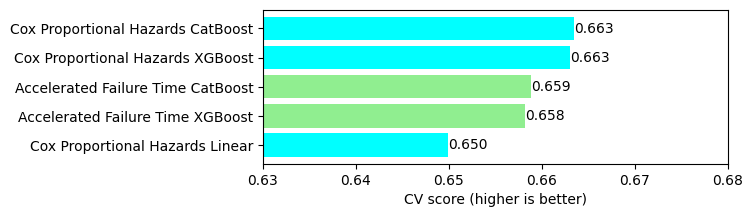

In [40]:
result_df = pd.DataFrame(basic_model_data['scores'], index=['score']).T
result_df = result_df.sort_values('score', ascending=True)

plt.figure(figsize=(6, len(result_df) * 0.4))

color = np.where(result_df.index.str.contains('Proportional'),
                 'cyan',
                 np.where(result_df.index.str.contains('Accelerated'), 'lightgreen', 
                          'lightpink'))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color=color)
plt.gca().bar_label(bars, fmt='%.3f')
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlim(0.63, 0.68)
plt.xticks(np.arange(0.63,0.69,0.01))
plt.xlabel('CV score (higher is better)')
plt.show()

**Obeservations:**
- The two best models are **Cox Proportional Hazards XGBoost** and **Cox Proportional Hazards CatBoost**, with the first being slightly better.
- **Accelerated Failure Time XGBoost** and **Accelerated Failure Time CatBoost** fell behind.
- The **linear Cox model** performed the worst out of all models.

Thus, Cox models with gradient boosting seem to perform best on this task.

##### t-AUC scores comparison
Next, we compare the **cross-validation t-AUC scores** of the basic models:

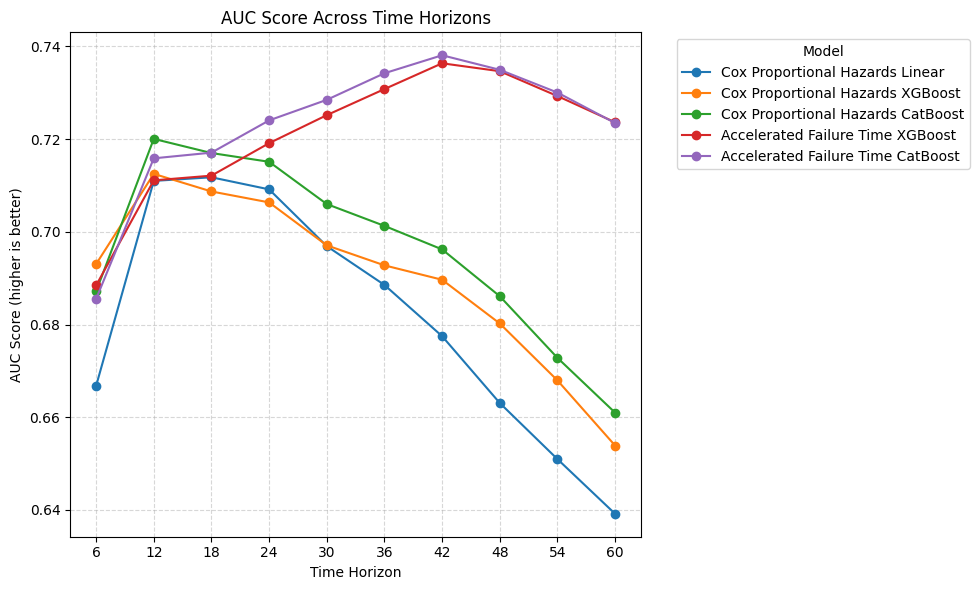

In [41]:
# Convert to DataFrame: rows = time horizons, columns = model names
df = pd.DataFrame(basic_model_data['aucs'])

# Sort time horizons (index) for proper line continuity
df = df.sort_index()

# Plot
plt.figure(figsize=(10, 6))
for model_name in df.columns:
    plt.plot(df.index, df[model_name], marker='o', label=model_name)

plt.xlabel("Time Horizon")
plt.ylabel("AUC Score (higher is better)")
plt.title("AUC Score Across Time Horizons")
plt.xticks(ticks=time_points)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observations:**
- All models perform similarly from months 6 to 24 (for the first 2 years).
- **Accelerated Failure Time** models became better predictors after the initial 2 years until year 5, and their performance stayed strong overall.
- The other models became weaker predictors, becoming worse every 6 months.

Therefore, the **Accelerated Failure Time** mdoels seem the best in this regard.

##### Runtime comparison
Finally, we compare the **cross-validation runtimes** of the basic models:

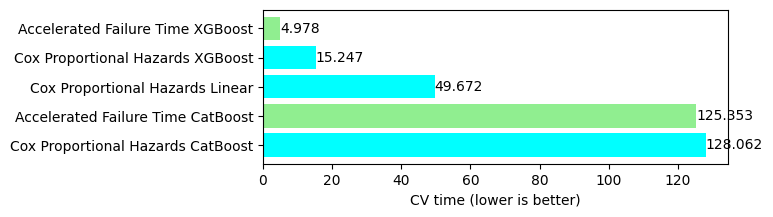

In [42]:
result_df = pd.DataFrame(basic_model_data['times'], index=['time']).T
result_df = result_df.sort_values('time', ascending=False)
# with pd.option_context("display.precision", 3): display(result_df)
plt.figure(figsize=(6, len(result_df) * 0.4))

color = np.where(result_df.index.str.contains('Proportional'),
                 'cyan',
                 np.where(result_df.index.str.contains('Accelerated'), 'lightgreen', 
                          'lightpink'))
bars = plt.barh(np.arange(len(result_df)), result_df.time, color=color)
plt.gca().bar_label(bars, fmt='%.3f')
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlabel('CV time (lower is better)')
plt.show()

**Observations:**
- **XGBoost models** are the fastest overall.
- In particular, **Accelerated Failure Time XGBoost** is the fastest model to complete cross-validation.
- The **linear Cox model** is slower but not as slow as the **CatBoost models** which are the slowest.

Overall, the cross-validation runtimes are still relatively short, likely because the dataset is small.

##### Final conclusion
In terms of C-index scores, our winning model would be the `Cox Proportional Hazards XGBoost` model.  
But in terms of t-AUC socres, the winning model would be the `Accelerated Failure Time CatBoost` model.  
Both are a strong choice to build upon for further improvements and comparisons.

We have decided to prefer C-index scores over t-AUC scores, as our main metric as it was the original metric given in the competition.  
Therefore, if required we will build upon `Cox Proportional Hazards XGBoost` as of now.

# Target transformation models and regression with mean squared error

The competition task can be interpreted as predicting the order of events for the patients.  
Who has an event first? Who second? ... Who has an event last? and who survives without an event at all?  
With a suitable target transformation, we can apply the usual regression algorithms which optimize MSE or similar metrics.

### XGBoost MSE loss for different target transformations
As the fastest basic models where in XGBoost, and our best model for now (by c-index scores) was one of them.  
We have chosen to run our target transformations with XGBoost.  
Later we will compare all of the target transformations we have tested to the best basic model.

For each transformation, we will plot a histogram to show what the transformation does to the target,  
and then fit regression models with MSE loss to each of the transformed targets.

As in the previous section (First basic models), we initially adopted hyperparameter settings from external examples and commonly recommended configurations.  
These parameters were chosen to provide strong, practical starting points, without dataset-specific tuning at this stage.  

In [43]:
def transform_model_fn(idx_tr, idx_va, transformation, model_params=None, features=features):
    """Evaluate a target transformation's cross-validation fold"""
    # Select features for training and validation sets
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    
    # Apply the transformation to create the new target for training
    y_tr = transformation(time=train.iloc[idx_tr].efs_time, event=train.iloc[idx_tr].efs)

    model_params = model_params or {
        'max_depth': 3,  
        'colsample_bytree': 0.5,  
        'subsample': 0.8,  
        'n_estimators': 2000,  
        'learning_rate': 0.02,  
        'enable_categorical': True,
        'min_child_weight': 80,
        'random_state': RANDOM_SEED,
    }

    # Define a simple XGBoost regressor with fixed hyperparameters
    model = xgboost.XGBRegressor(**model_params)
    
    # Fit the model on the transformed targets
    model.fit(X_tr, y_tr)
    
    # Predict the transformed target on validation set
    y_va_pred = model.predict(X_va)
    
    return model, y_va_pred, X_va

def plot_target_histogram(target, event, transformation_name):
    """Plot the target distribution by event status (using counts, not density)"""
    plt.figure(figsize=(6, 2))
    
    vmin = 1.09 * target.min() - 0.09 * target.max()
    vmax = 1.09 * target.max() - 0.09 * target.min()
    bins = np.linspace(vmin, vmax, 31)
    
    plt.hist(target[event == 0], bins=bins, label='No event (censored)', alpha=0.5)
    plt.hist(target[event == 1], bins=bins, label='Event observed', alpha=0.5)
    
    plt.xlim(vmin, vmax)
    plt.xlabel('Transformed Target Value')
    plt.ylabel('Count')
    plt.title('Target Distribution: ' + transformation_name)
    plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()

def evaluate_transformation(transformation, model_name='', show_plot=True, model_params=None, cv=True, display_results=True, features=features):
    """Evaluate a target transformation by plotting and cross-validation"""
    model_name = model_name or f'{transformation.__name__} XGBoost (MSE)'

    # Apply the transformation to the entire dataset
    target = transformation(time=train.efs_time, event=train.efs)
    
    # Plot the distribution
    if show_plot:
        plot_target_histogram(target, train.efs, model_name)
    
    # Evaluate model with cross-validation
    wrapped_transform_model_fn = lambda idx_tr, idx_va: transform_model_fn(idx_tr, idx_va, transformation, model_params, features)

    if cv:
        evaluate_model_cv(model_name, wrapped_transform_model_fn, display_results)
        print()
    else:
        evaluate_model_testset(model_name, wrapped_transform_model_fn)

### Target transformation - Survival probability stretching

Patients with known events have relatively small `efs_time` values (typically 0–15), while patients without events have much larger values (typically 15–160).  
In a standard regression setup, this imbalance makes it difficult for the model to focus on distinguishing early events, which are more important for evaluation.  

To address this, we transform the target using the Kaplan-Meier survival estimate.  
This transformation maps the `efs_time` to the survival probability at that time.  

- Patients with early events (low `efs_time`) are mapped to low survival probabilities (near 0).  
- Patients without events (high `efs_time`) are mapped to high survival probabilities (near 1).  

This way, the range of important patients (with events) is stretched, while the range of less important patients (without events) is compressed.  
The model can now better learn the relative order of patients with events by minimizing mean squared error on the transformed targets.  

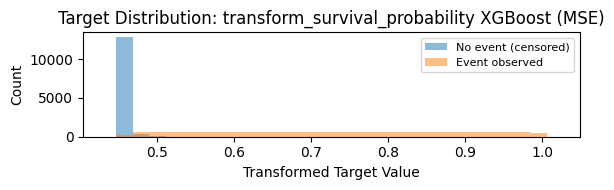

# Total time for transform_survival_probability XGBoost (MSE): 15.06 seconds
# Overall score for transform_survival_probability XGBoost (MSE): 0.664


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.676,0.680,0.682,0.682,0.673,0.679
Asian,0.690,0.684,0.692,0.681,0.689,0.687
Black or African-American,0.671,0.656,0.686,0.668,0.663,0.669
More than one race,0.669,0.682,0.662,0.689,0.693,0.679
Native Hawaiian or other Pacific Islander,0.676,0.655,0.662,0.680,0.660,0.667
White,0.666,0.661,0.673,0.678,0.671,0.670
mean,0.675,0.670,0.676,0.680,0.675,0.675
std,0.009,0.014,0.013,0.007,0.013,0.011
score,0.666,0.656,0.663,0.672,0.662,0.664


In [44]:
def transform_survival_probability(time, event):
    """Transform the target by predicting the survival probability using Kaplan-Meier to emphasize early events"""
    kmf = KaplanMeierFitter()
    kmf.fit(time, event)
    return kmf.survival_function_at_times(time).values

evaluate_transformation(transform_survival_probability)

To show a more detailed version of how a typical target transformation stretches and compresses the ranges, we have also created the next diagram.  
We use the transformation above as the example:

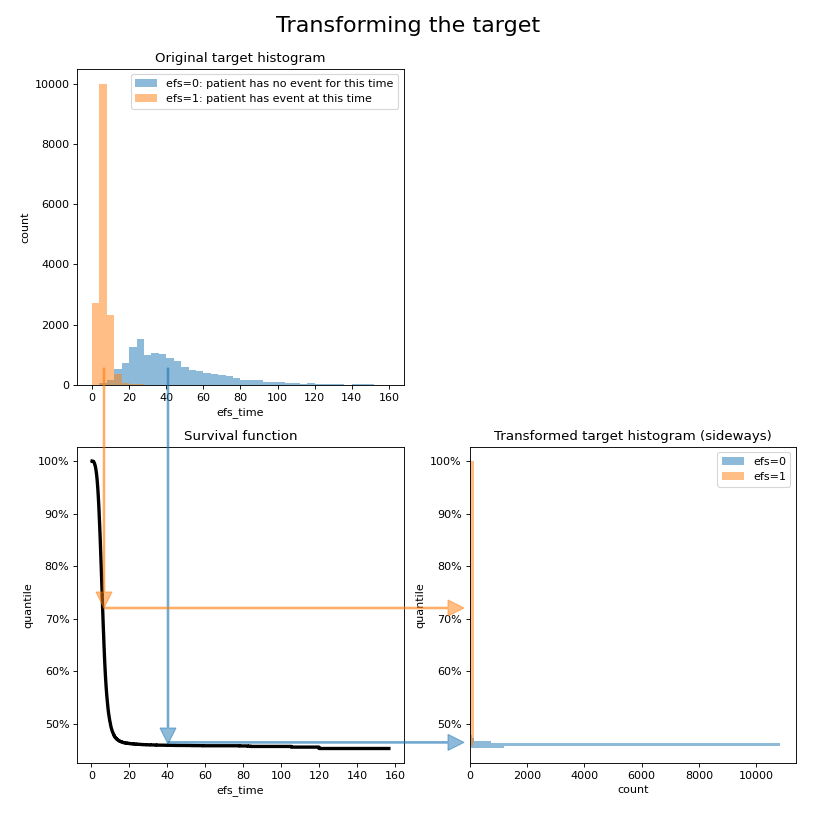

In [45]:
y_quantile = transform_survival_probability(time=train.efs_time, event=train.efs)
survival_df = survival_function(train)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=80)

axs[0, 0].hist(train.efs_time[train.efs == 0], bins=np.linspace(0, 160, 41), label='efs=0: patient has no event for this time', alpha=0.5)
axs[0, 0].hist(train.efs_time[train.efs == 1], bins=np.linspace(0, 160, 41), label='efs=1: patient has event at this time', alpha=0.5)
axs[0, 0].legend()
axs[0, 0].set_xlabel('efs_time')
axs[0, 0].set_ylabel('count')
axs[0, 0].set_title('Original target histogram')

axs[0, 1].set_axis_off()

axs[1, 0].step(survival_df.index, survival_df['survival_probability'], c='k', lw=3, where="post", label='[Overall]')
axs[1, 0].set_xlabel('efs_time')
axs[1, 0].set_ylabel("quantile")
axs[1, 0].set_title("Survival function")
axs[1, 0].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

axs[1, 1].hist(y_quantile[train.efs==0], bins=100, label="efs=0", orientation=u'horizontal', alpha=0.5)
axs[1, 1].hist(y_quantile[train.efs==1], bins=100, label="efs=1", orientation=u'horizontal', alpha=0.5)
axs[1, 1].legend()
axs[1, 1].set_ylabel("quantile")
axs[1, 1].set_xlabel("count")
axs[1, 1].set_title("Transformed target histogram (sideways)")
axs[1, 1].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.add_axes(ax)
ax.arrow(0.2, 0.55, 0, -0.47, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(0), alpha=0.5, head_width=0.02, head_length=0.02)
ax.arrow(0.2, 0.082, 0.37, 0, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(0), alpha=0.5, head_width=0.02, head_length=0.02)
ax.arrow(0.12, 0.55, 0, -0.3, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(1), alpha=0.5, head_width=0.02, head_length=0.02)
ax.arrow(0.12, 0.25, 0.45, 0, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(1), alpha=0.5, head_width=0.02, head_length=0.02)

plt.suptitle('Transforming the target', y=0.99, size=20)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout()
plt.show()

### Target transformation - Partial hazard stretching

Similar to the survival probability transformation, we want to help the model better distinguish patients with early events.  
Instead of using Kaplan-Meier survival estimates, we now use the partial hazard predicted by a Cox Proportional Hazards model.  

This transformation maps the `efs_time` to the predicted partial hazard:
- Patients with earlier events are mapped to higher partial hazards.  
- Patients without events are mapped to lower partial hazards.  

The Cox model captures more nuanced relationships between time and event occurrence compared to Kaplan-Meier, as it can model covariate effects if desired (although here we fit it only with `efs_time` and `event`).  
By training the regression model on the transformed partial hazard, we again stretch the range of patients with known events and compress the range for event-free patients, improving the model's ability to order patients correctly.  

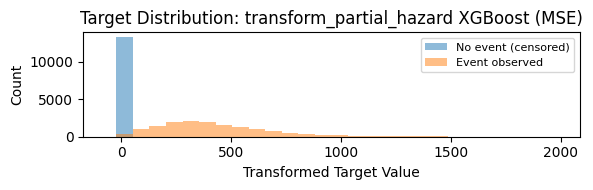

# Total time for transform_partial_hazard XGBoost (MSE): 29.79 seconds
# Overall score for transform_partial_hazard XGBoost (MSE): 0.663


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.671,0.683,0.682,0.680,0.671,0.677
Asian,0.692,0.685,0.693,0.682,0.689,0.688
Black or African-American,0.671,0.656,0.688,0.666,0.664,0.669
More than one race,0.668,0.679,0.663,0.689,0.693,0.678
Native Hawaiian or other Pacific Islander,0.673,0.655,0.661,0.678,0.663,0.666
White,0.664,0.657,0.672,0.678,0.671,0.668
mean,0.673,0.669,0.676,0.679,0.675,0.675
std,0.010,0.015,0.013,0.008,0.013,0.012
score,0.663,0.654,0.663,0.671,0.662,0.663


In [46]:
def transform_partial_hazard(time, event):
    """Transform the target by predicting the partial hazard using a Cox model to emphasize early events"""
    data = pd.DataFrame({'efs_time': time, 'efs': event, 'time': time, 'event': event})
    cph = CoxPHFitter()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cph.fit(data, duration_col='time', event_col='event')
    return cph.predict_partial_hazard(data)

evaluate_transformation(transform_partial_hazard)

### Target transformation - Separate events from non-events

This transformation explicitly separates patients with known events from those without events.  
First, patients without events are shifted to occur after all patients with known events.  
Next, all patients are ranked based on their shifted times:  
- Patients with earlier events receive higher ranks (after negation).  
- Patients without events are further pushed back in the ranking.  

Finally, the ranks are normalized and negated, so that patients with early events have higher transformed values, and event-free patients are compressed toward zero.

This transformation strongly encourages the model to prioritize ordering patients with known events, while minimizing attention to patients without events.

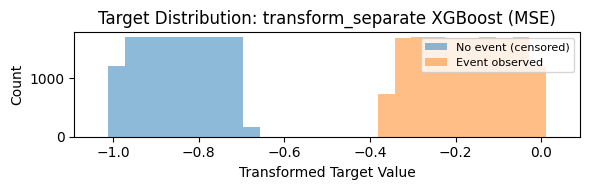

# Total time for transform_separate XGBoost (MSE): 15.45 seconds
# Overall score for transform_separate XGBoost (MSE): 0.660


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.678,0.689,0.680,0.689,0.673,0.681
Asian,0.696,0.677,0.694,0.686,0.690,0.689
Black or African-American,0.666,0.659,0.683,0.665,0.651,0.665
More than one race,0.670,0.682,0.660,0.689,0.697,0.680
Native Hawaiian or other Pacific Islander,0.674,0.659,0.668,0.676,0.659,0.667
White,0.668,0.650,0.662,0.657,0.667,0.661
mean,0.675,0.669,0.674,0.677,0.673,0.674
std,0.011,0.015,0.013,0.013,0.018,0.014
score,0.664,0.654,0.661,0.664,0.655,0.660


In [47]:
def transform_separate(time, event):
    """Transform the target by separating and ranking events higher than non-events"""
    transformed = time.values.copy()
    mx = transformed[event == 1].max() # last patient that has a known event
    mn = transformed[event == 0].min() # first patient that does not have a known event
    transformed[event == 0] = time[event == 0] + mx - mn
    transformed = rankdata(transformed)
    transformed[event == 0] += len(transformed) // 2
    transformed = transformed / transformed.max()
    return - transformed

evaluate_transformation(transform_separate)

### Target transformation - Rank and log-compress

This transformation builds on the idea of separating events from non-events and ranking the patients.  
First, patients without events are shifted to occur after all patients with known events.  
All patients are ranked:  
- Patients with earlier events receive higher ranks (after negation).  
- Patients without events are shifted even further back in the ranking.  

After ranking, a logarithmic transformation is applied to compress large rank differences:  
- Differences among early events are stretched out.  
- Differences among event-free patients are compressed.  

Finally, the ranks are normalized and negated, ensuring that early events are mapped to higher transformed values.  

This emphasizes the ordering among patients with early events while minimizing noise from the event-free population.  

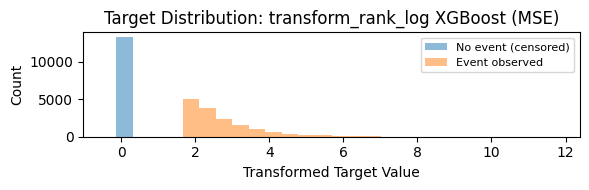

# Total time for transform_rank_log XGBoost (MSE): 15.42 seconds
# Overall score for transform_rank_log XGBoost (MSE): 0.665


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.678,0.694,0.687,0.688,0.680,0.686
Asian,0.701,0.685,0.694,0.692,0.694,0.693
Black or African-American,0.674,0.663,0.692,0.669,0.659,0.672
More than one race,0.675,0.683,0.669,0.694,0.708,0.686
Native Hawaiian or other Pacific Islander,0.675,0.666,0.669,0.679,0.667,0.671
White,0.667,0.654,0.669,0.667,0.674,0.666
mean,0.678,0.674,0.680,0.682,0.680,0.679
std,0.012,0.016,0.012,0.012,0.018,0.014
score,0.667,0.659,0.668,0.670,0.662,0.665


In [48]:
def transform_rank_log(time, event):
    """Transform the target by ranking patients and applying logarithmic compression to emphasize early events"""
    transformed = time.values.copy()
    mx = transformed[event == 1].max() # last patient that has a known event
    mn = transformed[event == 0].min() # first patient that does not have a known event
    transformed[event == 0] = time[event == 0] + mx - mn
    transformed = rankdata(transformed)
    transformed[event == 0] += len(transformed) * 2
    transformed = transformed / transformed.max()
    transformed = np.log(transformed)
    return - transformed

evaluate_transformation(transform_rank_log)

### Target transformation - Quantile stretch for events

This transformation focuses only on patients with known events.  
A quantile transformation is applied to the eventful patients' `efs_time`, spreading their values uniformly between 0 and 1.  
- Early events are mapped to lower quantiles.  
- Later events are mapped to higher quantiles.  

Patients without events are all assigned a constant value slightly smaller than the minimum quantile value (by `-0.3`), ensuring a clear separation between events and non-events.  

This allows the model to focus entirely on correctly ordering the patients with events, while ignoring non-events during training.  

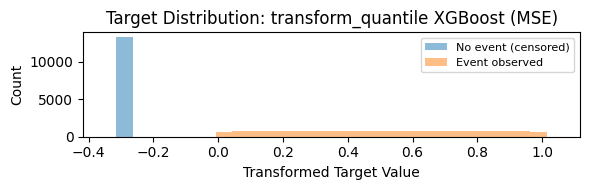

# Total time for transform_quantile XGBoost (MSE): 15.06 seconds
# Overall score for transform_quantile XGBoost (MSE): 0.668


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.683,0.693,0.687,0.690,0.683,0.687
Asian,0.702,0.685,0.694,0.690,0.694,0.693
Black or African-American,0.675,0.663,0.690,0.674,0.661,0.673
More than one race,0.677,0.686,0.669,0.695,0.707,0.687
Native Hawaiian or other Pacific Islander,0.677,0.667,0.670,0.681,0.666,0.672
White,0.672,0.661,0.672,0.670,0.676,0.670
mean,0.681,0.676,0.680,0.683,0.681,0.680
std,0.011,0.014,0.011,0.010,0.017,0.013
score,0.670,0.662,0.669,0.674,0.664,0.668


In [49]:
def transform_quantile(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times"""
    transformed = np.full(len(time), np.nan)
    transformed_with_event = quantile_transform(- time[event == 1].values.reshape(-1, 1)).ravel()
    transformed[event == 1] = transformed_with_event
    transformed[event == 0] = transformed_with_event.min() - 0.3
    return transformed

evaluate_transformation(transform_quantile)

### Summary of target transformations

| Transformation    | Key Idea |
| -------- | ------- |
| transform_survival_probability  | Predict survival probability (Kaplan-Meier) to stretch early events. |
| transform_partial_hazard | Predict partial hazard (Cox model) to stretch early events. |
| transform_separate    | Separate and rank events higher than non-events. |
| transform_rank_log    | Rank patients and apply logarithmic compression to emphasize early events. |
| transform_quantile    | Quantile-transform events and separate non-events below them. |

### Comparison of target tranformations
All transformations are designed to help the model better distinguish patients who experience early events, rather than focusing on the exact timing of long survivors.  
They achieve this by stretching the range of eventful patients and compressing the range of event-free patients.  
- **Survival probability** and **partial hazard** transformations use survival models to create smoother, probabilistic targets.  
- **Separation** and **rank-log** transformations impose a harder split between events and non-events, which can sometimes make learning easier but slightly noisier.  
- **Quantile** transformation spreads eventful patients uniformly and separates non-events cleanly, offering a simple but effective target.  

In the previous section, we identified the `Cox Proportional Hazards XGBoost` model as the best performing baseline in terms of (c-index) score,  
and the `Accelerated Failure Time CatBoost` model as the best performing in terms of t-AUC scores.  
Now, after introducing several target transformation methods, we compare them directly against these baseline models.

We again evaluate:
- C-index score - higher is better.
- t-AUC Scores - higher is better.
- Runtime - lower is better.

##### C-index scores comparison
We start by looking at the **cross-validation C-index scores** of the target transformation models:

In [50]:
transformation_models = ['transform_survival_probability XGBoost (MSE)', 'transform_partial_hazard XGBoost (MSE)', 'transform_separate XGBoost (MSE)', 'transform_rank_log XGBoost (MSE)', 'transform_quantile XGBoost (MSE)']
baseline_models = ['Cox Proportional Hazards XGBoost', 'Accelerated Failure Time CatBoost']

# Filter all_model_data to only include entries for models in basic_models
transformation_model_data = {
    key: {model: val for model, val in all_model_data[key].items() if model in transformation_models or model in baseline_models}
    for key in all_model_data
}

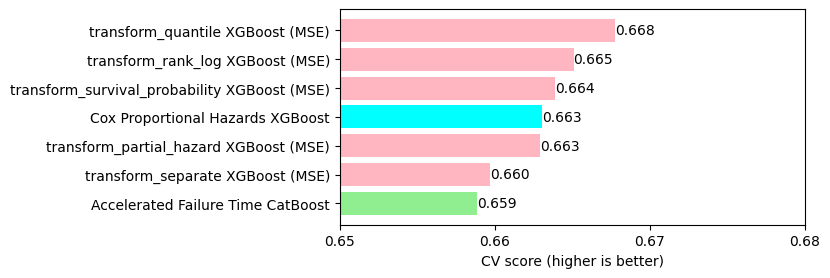

In [51]:
result_df = pd.DataFrame(transformation_model_data['scores'], index=['score']).T
result_df = result_df.sort_values('score', ascending=True)

plt.figure(figsize=(6, len(result_df) * 0.4))

color = np.where(result_df.index.str.contains('Proportional'),
                 'cyan',
                 np.where(result_df.index.str.contains('Accelerated'), 'lightgreen', 
                          'lightpink'))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color=color)
plt.gca().bar_label(bars, fmt='%.3f')
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlim(0.65, 0.68)
plt.xticks([0.65, 0.66, 0.67, 0.68])
plt.xlabel('CV score (higher is better)')
plt.show()

**Observations:**
- Some transformations slightly outperform the c-index baseline (`Cox Proportional Hazards XGBoost`).
- All transformations outperform the t-AUC baseline (`Accelerated Failure Time CatBoost`).
- `transform_quantile XGBoost (MSE)` achieves the best C-index score.

##### t-AUC scores comparison
Next, we compare the **cross-validation t-AUC scores** of the basic models:

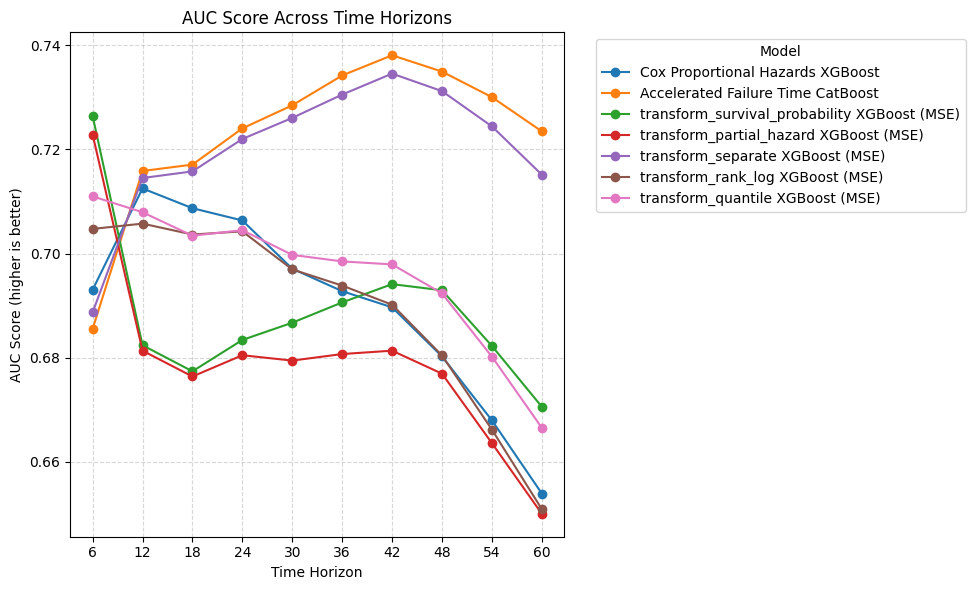

In [52]:
# Convert to DataFrame: rows = time horizons, columns = model names
df = pd.DataFrame(transformation_model_data['aucs'])

# Sort time horizons (index) for proper line continuity
df = df.sort_index()

# Plot
plt.figure(figsize=(10, 6))
for model_name in df.columns:
    plt.plot(df.index, df[model_name], marker='o', label=model_name)

plt.xlabel("Time Horizon")
plt.ylabel("AUC Score (higher is better)")
plt.title("AUC Score Across Time Horizons")
plt.xticks(ticks=time_points)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observations:**
- From months 6 to 12 many models have drastic changes.
- After the first year, it seems there are 3 groups of models in terms of performance, where the lower 2 groups converge into 1 after the third year,  
    and continue to get rapidly worse.
- The best performing model in terms of C-index scores, `transform_quantile XGBoost (MSE)`,  
    is within the middle group that becomes the worse performing group (but is one of the top models there).
- In the best group, `transform_separate XGBoost (MSE)` joins `Accelerated Failure Time CatBoost` as the best performing model in this metric,  
    but only between the transformation models, as it is still slightly worse compared to the latter.  
    This is is interesting as both are the worst performing models in C-index scores, in the latest comparison.

Therefore, the `Accelerated Failure Time CatBoost` stays the best in this regard.

##### Runtime comparison
Finally, we compare the **cross-validation runtimes** of the target transformation models:

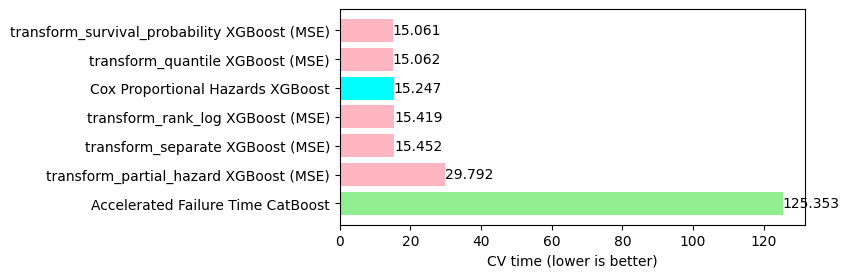

In [53]:
result_df = pd.DataFrame(transformation_model_data['times'], index=['time']).T
result_df = result_df.sort_values('time', ascending=False)
# with pd.option_context("display.precision", 3): display(result_df)
plt.figure(figsize=(6, len(result_df) * 0.4))

color = np.where(result_df.index.str.contains('Proportional'),
                 'cyan',
                 np.where(result_df.index.str.contains('Accelerated'), 'lightgreen', 
                          'lightpink'))
bars = plt.barh(np.arange(len(result_df)), result_df.time, color=color)
plt.gca().bar_label(bars, fmt='%.3f')
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlabel('CV time (lower is better)')
plt.show()

**Observations:**
- All transformation models are rather fast, and have similar run times to the `Cox Proportional Hazards XGBoost` model.
- All of them are much faster then the `Accelerated Failure Time CatBoost` model.

##### Final conclusion

Target transformations can slightly outperform the `Cox Proportional Hazards XGBoost` C-index baseline.  
Particularly `transform_quantile XGBoost (MSE)`, which was the best performing in that metric.

None of them managed to outperform the `Accelerated Failure Time CatBoost` t-AUC baseline.  
This might be due to us focusing on the first metric in choosing the base model to run our target tranformations on.

Again, we have decided to prefer C-index scores over t-AUC scores in our choices as it was the original metric given in the competition.  
Therefore, we will build upon `transform_quantile XGBoost (MSE)` in hopes of improving the C-index scores.

# Feature importance
As `transform_quantile XGBoost (MSE)` was our best model in terms of C-index scores,  
let's delve deeper into what features it cared about most:

### Reviewing the feature importance

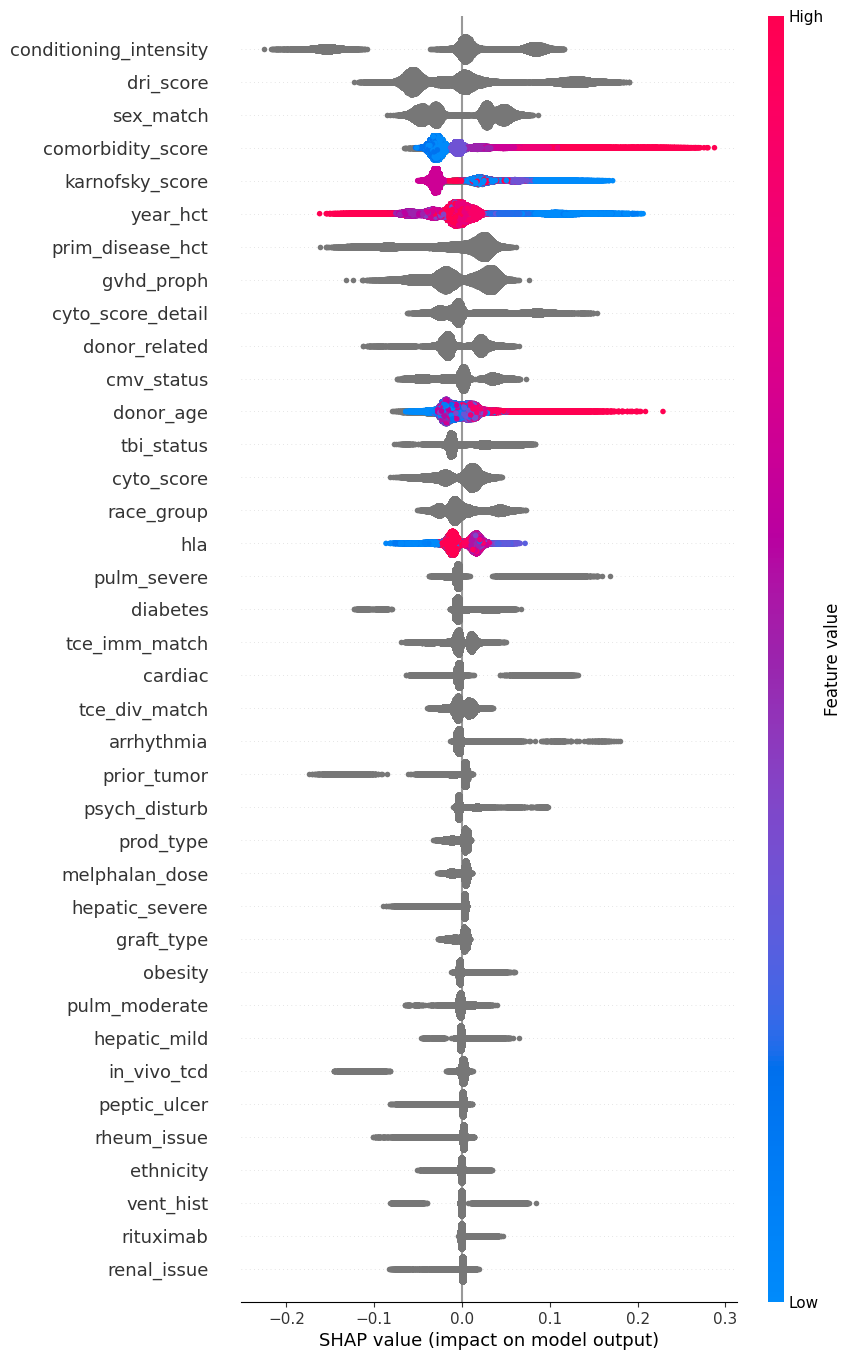

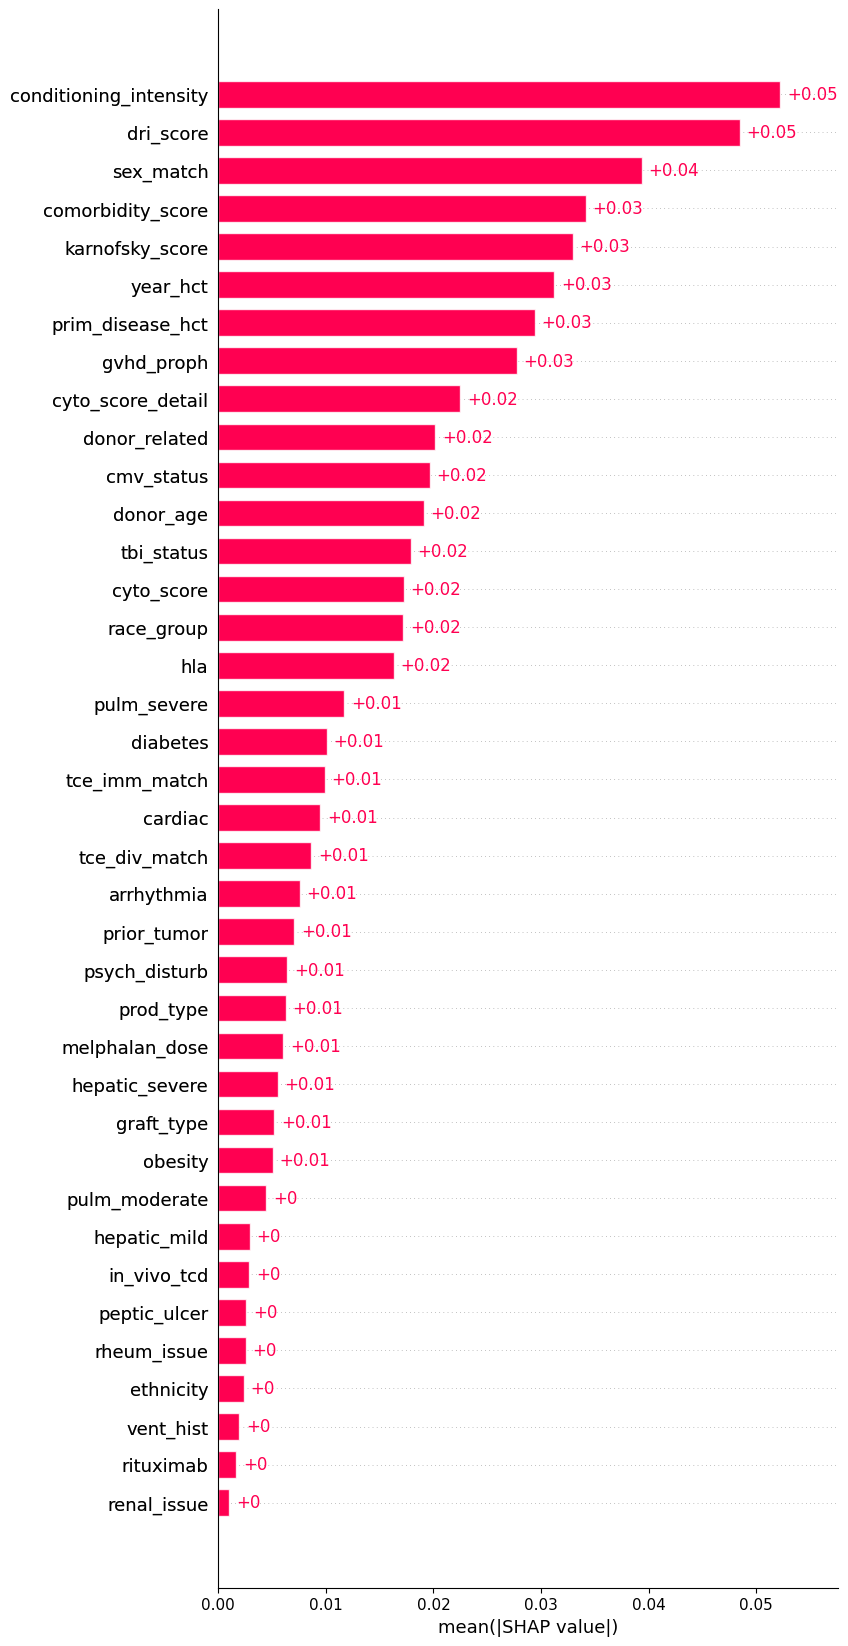

In [54]:
def display_feature_importance(model_name, features=features):
    # Collect SHAP values and corresponding X data for all CV folds
    shap_values_list = []

    for fold, (idx_tr, _) in enumerate(kf.split(train.loc[train_indices], train.loc[train_indices, 'race_group'])):
        model = all_model_data['models'][model_name][fold]
        X_tr = train.iloc[idx_tr][features]
        
        explainer = shap.Explainer(model, seed=1)
        fold_shap_values = explainer(X_tr)  # shape: (n_samples, n_features)
        
        shap_values_list.append(fold_shap_values)

    # Combine a list of shap.Explanation objects (one per fold)
    combined_shap_values = np.vstack([shap_vals.values for shap_vals in shap_values_list])
    combined_base_values = np.concatenate([shap_vals.base_values for shap_vals in shap_values_list])
    combined_data = np.vstack([shap_vals.data for shap_vals in shap_values_list])

    # Create a new shap.Explanation object with the combined data
    shap_values = shap.Explanation(
        values=combined_shap_values,
        base_values=combined_base_values,
        data=combined_data,
        feature_names=features  # make sure `features` is in the correct order
    )

    max_display = 50
    shap.plots.beeswarm(shap_values, max_display)
    shap_plots.bar(shap_values.abs.mean(0), max_display)

display_feature_importance('transform_quantile XGBoost (MSE)')

The most impactful features make sense.  
Most of them are grades and descriptions relating to the patient's health state.  
For example the `conditioning_intensity` describes how a patient's body was prepared for HCT.  
It fits that they contribute the most to the score as they reflect the physical state the patient was in before HCT.

Other imapctful features like `sex_match` and `year_hct` are interesting.  
The latter means that patients that had gone through HCT in more recent years, are less likely to have an event.  
This might be due to healthcare improvements throughout the years, but it is more likely to be recency bias,  
as there was less followup and time passing for these patients.

### Removing the least impactful features

We can also see that there are features that don't have as much impact (close to zero overall).  
We are not sure why they are not as important as some of the middle features, but a quetion does arise:  
Can we remove them to simplify our model? let's try that.  

We will remove the bottom 5 features (least impactful).

In [55]:
# Remove features with low importance
low_importance_features = ['renal_issue', 'rituximab', 'vent_hist', 'rheum_issue', 'ethnicity']
features_without_bottom = [f for f in features if f not in low_importance_features]

evaluate_transformation(transformation=transform_quantile, model_name='best model after removing 5 low importance features', show_plot=False, features=features_without_bottom)

# Total time for best model after removing 5 low importance features: 14.60 seconds
# Overall score for best model after removing 5 low importance features: 0.669


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.685,0.693,0.686,0.687,0.685,0.687
Asian,0.702,0.686,0.697,0.694,0.693,0.694
Black or African-American,0.674,0.665,0.691,0.672,0.663,0.673
More than one race,0.675,0.685,0.671,0.697,0.707,0.687
Native Hawaiian or other Pacific Islander,0.678,0.667,0.673,0.684,0.668,0.674
White,0.673,0.661,0.673,0.672,0.675,0.671
mean,0.681,0.676,0.682,0.684,0.682,0.681
std,0.011,0.013,0.011,0.011,0.016,0.012
score,0.670,0.663,0.671,0.674,0.666,0.669


By doing this removal, we got a slight positive impact on the model's performance (`+0.001`).  
Can we do that again and still improve the model? let's remove 5 more features from the bottom.

In [56]:
# save a copy of the training data if feature removal does not work
low_importance_features_save = low_importance_features.copy()

# Remove features with low importance
low_importance_features = low_importance_features + ["obesity", "pulm_moderate", "in_vivo_tcd", "hepatic_mild", "peptic_ulcer"]
features_without_bottom = [f for f in features if f not in low_importance_features]

evaluate_transformation(transform_quantile, 'best model after removing 10 low importance features', show_plot=False, features=features_without_bottom)

# Total time for best model after removing 10 low importance features: 13.86 seconds
# Overall score for best model after removing 10 low importance features: 0.667


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.683,0.692,0.684,0.688,0.682,0.686
Asian,0.701,0.687,0.695,0.693,0.694,0.694
Black or African-American,0.672,0.664,0.691,0.672,0.661,0.672
More than one race,0.675,0.686,0.671,0.696,0.707,0.687
Native Hawaiian or other Pacific Islander,0.674,0.664,0.671,0.687,0.664,0.672
White,0.670,0.659,0.672,0.673,0.676,0.670
mean,0.679,0.675,0.681,0.685,0.680,0.680
std,0.011,0.015,0.011,0.010,0.018,0.013
score,0.668,0.661,0.670,0.675,0.663,0.667


While removing the bottom 5 features slightly improved the results, 10 seems to revert us to the original state.  
We would like to stay with the improved model so we will keep only the removal of the bottom 5.  

In [57]:
features_without_bottom = [f for f in features if f not in low_importance_features_save]

How did the removal impact the feature importance?

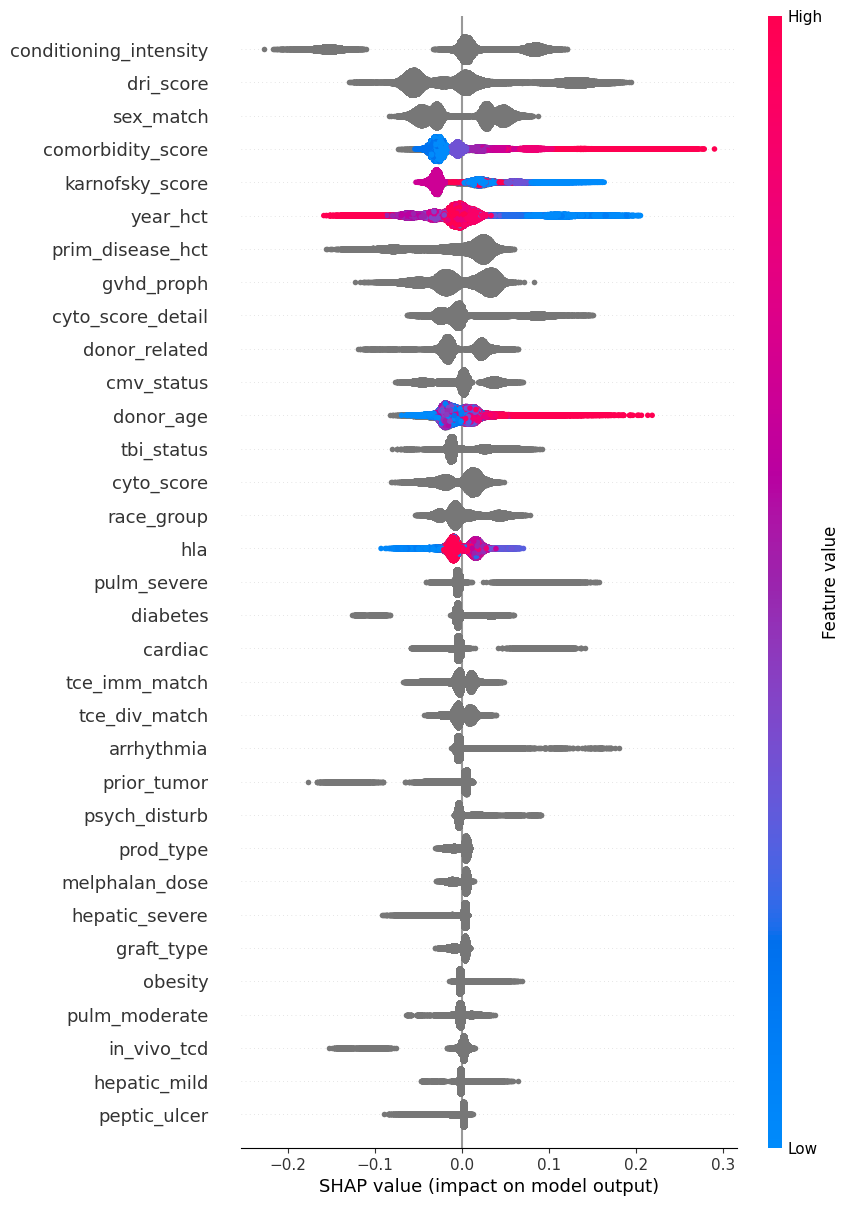

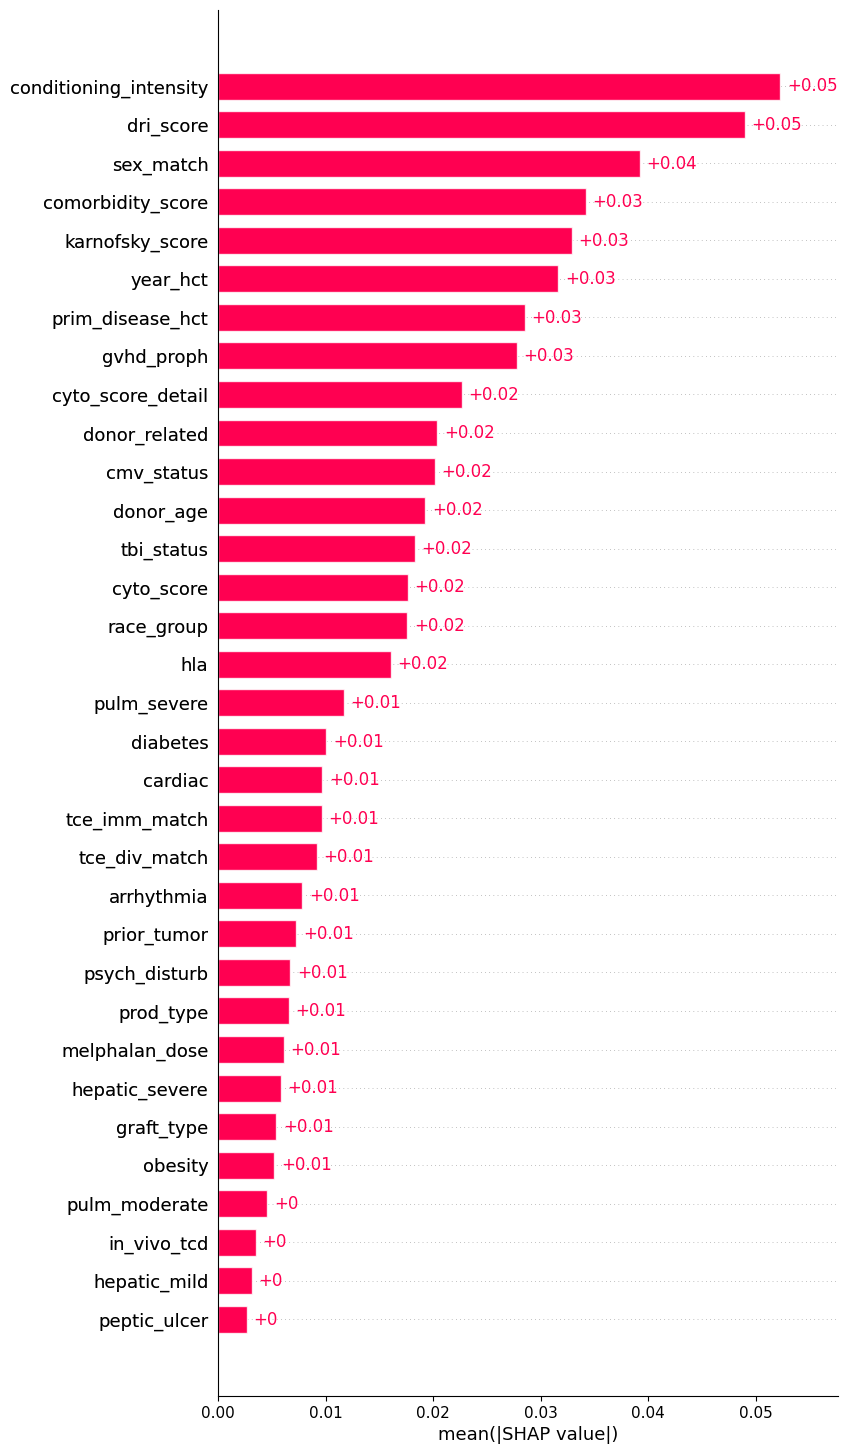

In [58]:
display_feature_importance('best model after removing 5 low importance features', features_without_bottom)

From what we can see, there doesn't seem to be a noticeable change in feature importance across the model.  

# Hyperparameter Tuning for our best model
After selecting `transform_quantile` as our best-performing model, and removing unimpactful features,  
we wanted to see if we could push the model even further by tuning its hyperparameters.

Machine learning models like XGBoost come with a range of configurable settings — such as tree depth, learning rate, and regularization strength — that can significantly affect their performance.  
These are called **hyperparameters**, and choosing the right values often makes the difference between a good model and a great one.

Instead of adjusting these manually, we used **Optuna**, a modern and flexible hyperparameter optimization framework.  
It works by trying many combinations of values and learning from each trial to focus on the most promising areas of the search space.

In this section, we:
- Define a fairness-aware evaluation score to guide tuning (`mean - std` of C-index across race groups)
- Use Optuna to search for a better set of hyperparameters
- Re-evaluate the best model using our standard metrics

Let’s see what we can improve!

In [59]:
def evaluate_hyperparameter_tuning_cv(model_fn):
    """Cross-validate model with hyperparameter tuning and return the score."""
    all_fold_results = []

    for fold, (idx_tr, idx_va) in enumerate(kf.split(train.loc[train_indices], train.loc[train_indices, 'race_group'])):
        idx_tr = train_indices[idx_tr]
        idx_va = train_indices[idx_va]

        _, y_va_pred, X_va = model_fn(idx_tr, idx_va)
        fold_metrics = evaluate(y_va_pred, X_va, idx_va)
        all_fold_results.append(fold_metrics)

    scores, _ = aggregate_cv_results(all_fold_results)
    return scores.loc['score', 'Overall']

In [60]:
# Define the objective function for Optuna
def objective(trial: optuna.Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1500, 2500),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': 0.02,  
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.7),
        'min_child_weight': trial.suggest_float('min_child_weight', 30, 85),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 2.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1, log=True),
        'enable_categorical': True,
        'random_state': RANDOM_SEED
    }

    wrapped_transform_model_fn = lambda idx_tr, idx_va: transform_model_fn(idx_tr, idx_va, transform_quantile, params, features_without_bottom)
    score = evaluate_hyperparameter_tuning_cv(wrapped_transform_model_fn)
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=10)

# Extract and finalize best params
best_params = study.best_params.copy()
best_params['enable_categorical'] = True
best_params['learning_rate'] = 0.02  # Make sure it's included for consistency
best_params['random_state'] = RANDOM_SEED

[I 2025-05-05 18:14:27,260] A new study created in memory with name: no-name-4abb7a31-0fdb-4c55-a238-4928f4120392
[I 2025-05-05 18:14:59,077] Trial 0 finished with value: 0.6629122780906924 and parameters: {'n_estimators': 2404, 'max_depth': 6, 'subsample': 0.7112540313625768, 'colsample_bytree': 0.487028297037688, 'min_child_weight': 65.69253974414787, 'reg_lambda': 1.6827509401260314, 'reg_alpha': 0.3118386172127775}. Best is trial 0 with value: 0.6629122780906924.
[I 2025-05-05 18:15:21,289] Trial 1 finished with value: 0.6681974195940856 and parameters: {'n_estimators': 2020, 'max_depth': 5, 'subsample': 0.756484530510672, 'colsample_bytree': 0.3094023487673182, 'min_child_weight': 55.32317978787106, 'reg_lambda': 1.150419970821751, 'reg_alpha': 0.17607974458376138}. Best is trial 1 with value: 0.6681974195940856.
[I 2025-05-05 18:15:44,553] Trial 2 finished with value: 0.6658258483138054 and parameters: {'n_estimators': 1784, 'max_depth': 6, 'subsample': 0.6186081183743152, 'colsa

Of course, running only 10 trials with Optuna is far from enough to properly explore the hyperparameter space or reach optimal results.
However, running a full-scale hyperparameter tuning process takes a significant amount of time — often several hours or even days, depending on the model complexity and parameter ranges.

To keep this notebook runnable in a reasonable time for demonstration purposes, we’re limiting Optuna to just 10 trials here, mainly to show that the optimization process is functioning as expected.

The actual `best_params` we use later were obtained through much more extensive tuning – across a wide parameter space, and over many sessions and iterations.  
We refined the ranges and reran the optimization multiple times until we consistently saw convergence toward a strong configuration.
These represent the best-performing parameters we’ve found so far, and we will use them to evaluate the final version of our model.

In [61]:
best_params = {
    'n_estimators': 2129, 
    'max_depth': 4, 
    'subsample': 0.7563910760668933, 
    'colsample_bytree': 0.41756217986008215, 
    'min_child_weight': 82.91031620192452, 
    'reg_lambda': 1.868629085705842, 
    'reg_alpha': 0.12173745769330951,
    'learning_rate': 0.02,
    'enable_categorical': True,
    'random_state': RANDOM_SEED
}

# === Evaluate Tuned Model ===
evaluate_transformation(transformation=transform_quantile, model_name='best model (Optuna Tuned)', show_plot=False, model_params=best_params, features=features_without_bottom)

# Total time for best model (Optuna Tuned): 19.17 seconds
# Overall score for best model (Optuna Tuned): 0.669


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Overall
American Indian or Alaska Native,0.686,0.692,0.684,0.690,0.680,0.686
Asian,0.704,0.685,0.691,0.692,0.694,0.693
Black or African-American,0.673,0.667,0.692,0.674,0.664,0.674
More than one race,0.676,0.686,0.671,0.694,0.706,0.687
Native Hawaiian or other Pacific Islander,0.674,0.665,0.672,0.686,0.666,0.673
White,0.677,0.662,0.677,0.675,0.678,0.674
mean,0.682,0.676,0.681,0.685,0.681,0.681
std,0.012,0.013,0.009,0.009,0.016,0.012
score,0.670,0.663,0.672,0.677,0.665,0.669


### Reflections on the Tuning Process

Once tuning was complete, we took the best parameter set and evaluated it using the same cross-validation strategy and fairness-aware metric as before.

The results showed a **modest but consistent improvement** in overall model performance.  
This confirmed that our manually chosen parameters were already quite good — but a bit of focused tuning helped squeeze out some extra performance.

That said, we also saw that improvements in the overall score didn’t always translate into better or fairer predictions across all race groups.  
In fact, some parameter combinations boosted the average score while increasing variability between groups.  
This highlights an important takeaway: **tuning for pure performance needs to be balanced with fairness goals**, especially in sensitive domains like healthcare.

Overall, this process gave us a more refined version of our best model and taught us the value (and limits) of automated tuning in real-world problems.

# Final comparisons
To conclude our modeling journey,  
we now compare select models from each major section to evaluate the overall improvement.
We also compare to a new random model.

We select:
- **Random order**: A random order model as another baseline.
- **Cox Proportional Hazards Linear**: A linear model that we introduced in the basic models section.
- **Cox Proportional Hazards XGBoost**: The best C-index model from the basic models section.
- **Accelerated Failure Time CatBoost**: The best t-AUC model overall.
- **transform_quantile XGBoost (MSE)**: The best C-index model overall (which we will also reference as the best model as C-index is our main metric).
- **best model after removing 5 low importance features**: The best C-index model, with the 5 least important features removed.
- **best model (Optuna Tuned)**: The best C-index model with 5 removed features, and hyperparameter tuning.

We first run the models:  
1. With CV - as until now.
2. On the entire train dataset and be tested upon the test dataset we have saved beforehand.

We will compare all models like before by C-index scores and by t-AUC scores.

In [62]:
def random_order(idx_tr, idx_va):
    """Returns a model that assigns a random order to the validation set."""
    X_va = train.iloc[idx_va][features]
    n = len(idx_va)
    
    # Generate a random permutation of integers 1 to n
    y_va_pred = np.random.permutation(np.arange(1, n + 1))
    
    # No actual model, but we return a dummy object for consistency
    model = None
    return model, y_va_pred, X_va

In [63]:
# Eevaluate the random order model
evaluate_model_cv('Random order', random_order, display_results=False)

# Evaluate on test set
evaluate_model_testset('Random order', random_order)
evaluate_model_testset('Cox Proportional Hazards Linear', linear_cox)
evaluate_model_testset('Cox Proportional Hazards XGBoost', cox_xgboost)
evaluate_model_testset('Accelerated Failure Time CatBoost', aft_catboost)
evaluate_transformation(transform_quantile, show_plot=False, cv=False)
evaluate_transformation(transform_quantile, model_name='best model after removing 5 low importance features', show_plot=False, cv=False, features=features_without_bottom)
evaluate_transformation(transform_quantile, model_name='best model (Optuna Tuned)', show_plot=False, model_params=best_params, cv=False, features=features_without_bottom)

# Total time for Random order: 1.68 seconds
# Test evaluation completed for Random order: 0.04 seconds
# Test evaluation completed for Cox Proportional Hazards Linear: 11.06 seconds
# Test evaluation completed for Cox Proportional Hazards XGBoost: 2.94 seconds
# Test evaluation completed for Accelerated Failure Time CatBoost: 30.91 seconds
# Test evaluation completed for transform_quantile XGBoost (MSE): 3.03 seconds
# Test evaluation completed for best model after removing 5 low importance features: 2.82 seconds
# Test evaluation completed for best model (Optuna Tuned): 3.84 seconds


### C-index scores comparison
We start by looking at the **cross-validation C-index scores** of the selected models:

In [64]:
selected_models = ['Random order', 'Cox Proportional Hazards Linear', 'Cox Proportional Hazards XGBoost', 'Accelerated Failure Time CatBoost', 'transform_quantile XGBoost (MSE)', 'best model after removing 5 low importance features', 'best model (Optuna Tuned)']

# Filter all_model_data to only include entries for models in basic_models
selected_model_data = {
    key: {model: val for model, val in all_model_data[key].items() if model in selected_models}
    for key in all_model_data
}

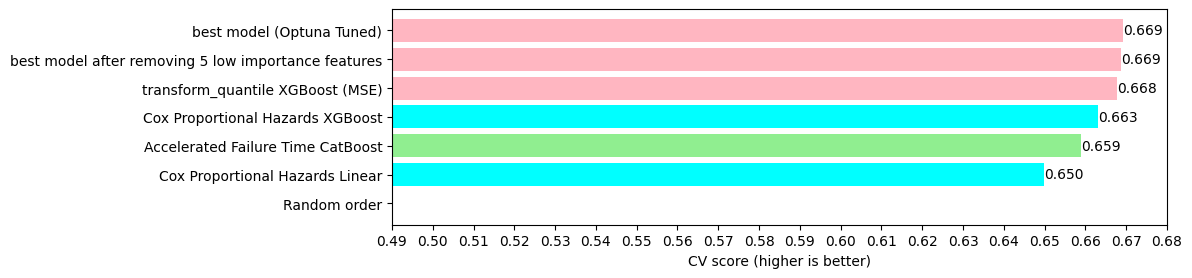

In [65]:
result_df = pd.DataFrame(selected_model_data['scores'], index=['score']).T
result_df = result_df.sort_values('score', ascending=True)

plt.figure(figsize=(10, len(result_df) * 0.4))

color = np.where(result_df.index.str.contains('Proportional'),
                 'cyan',
                 np.where(result_df.index.str.contains('Accelerated'), 'lightgreen', 
                          'lightpink'))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color=color)
plt.gca().bar_label(bars, fmt='%.3f')
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlim(0.49, 0.68)
plt.xticks(np.arange(0.49,0.68,0.01))
plt.xlabel('CV score (higher is better)')
plt.show()

Next we will look at the **test set C-index scores** of the selected models:

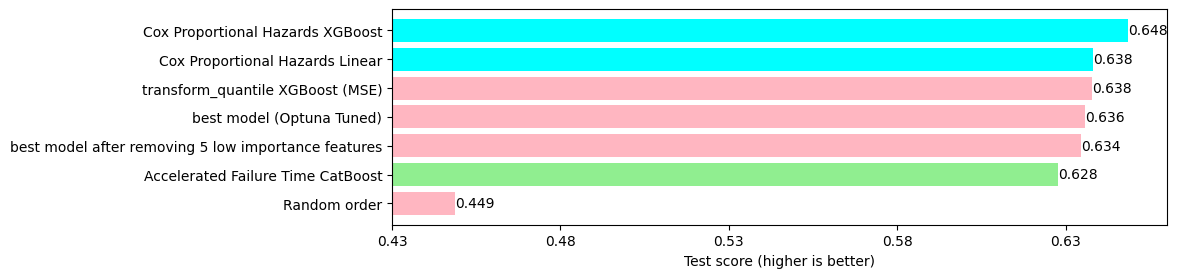

In [66]:
result_df = pd.DataFrame(all_tests['scores'], index=['score']).T
result_df = result_df.sort_values('score', ascending=True)

plt.figure(figsize=(10, len(result_df) * 0.4))

color = np.where(result_df.index.str.contains('Proportional'),
                 'cyan',
                 np.where(result_df.index.str.contains('Accelerated'), 'lightgreen', 
                          'lightpink'))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color=color)
plt.gca().bar_label(bars, fmt='%.3f')
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlim(0.43, 0.66)
plt.xticks(np.arange(0.43,0.66,0.05))
plt.xlabel('Test score (higher is better)')
plt.show()

**Observations:**
- The `Random order` model fails completely compared to other models.
- In terms of CV scores, we see the intended improvements throughout our models.
- Sadly for the test scores, our models' ranking and scores changes quite a bit: 
    - All scores get worse, and the `Cox Proportional Hazards XGBoost` model becomes the best model overall.
    - The feature removal seemed to matter alot more for this test, but our hyperparameter tuning actually made the model have a worse performance.
    - These scores reflect a degree of overfitting,  
        this is probably due to us training and improving the models on the CV scores, and both our train and test sets being quite small.

### t-AUC scores comparison
Now, we compare the **cross-validation t-AUC scores** of the selected models:

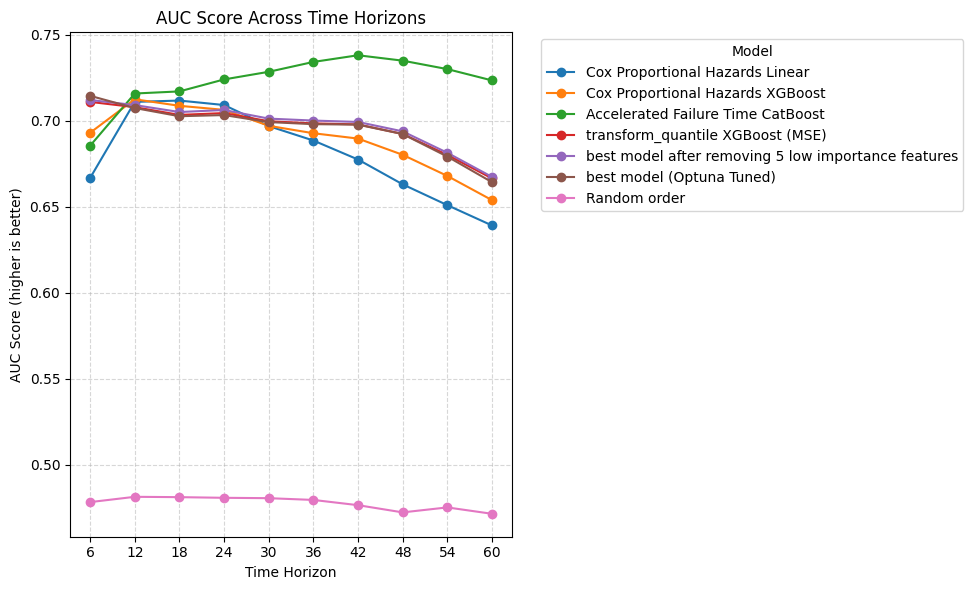

In [67]:
# Convert to DataFrame: rows = time horizons, columns = model names
df = pd.DataFrame(selected_model_data['aucs'])

# Sort time horizons (index) for proper line continuity
df = df.sort_index()

# Plot
plt.figure(figsize=(10, 6))
for model_name in df.columns:
    plt.plot(df.index, df[model_name], marker='o', label=model_name)

plt.xlabel("Time Horizon")
plt.ylabel("AUC Score (higher is better)")
plt.title("AUC Score Across Time Horizons")
plt.xticks(ticks=time_points)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Finally, we compare the **test set t-AUC scores** of the selected models:

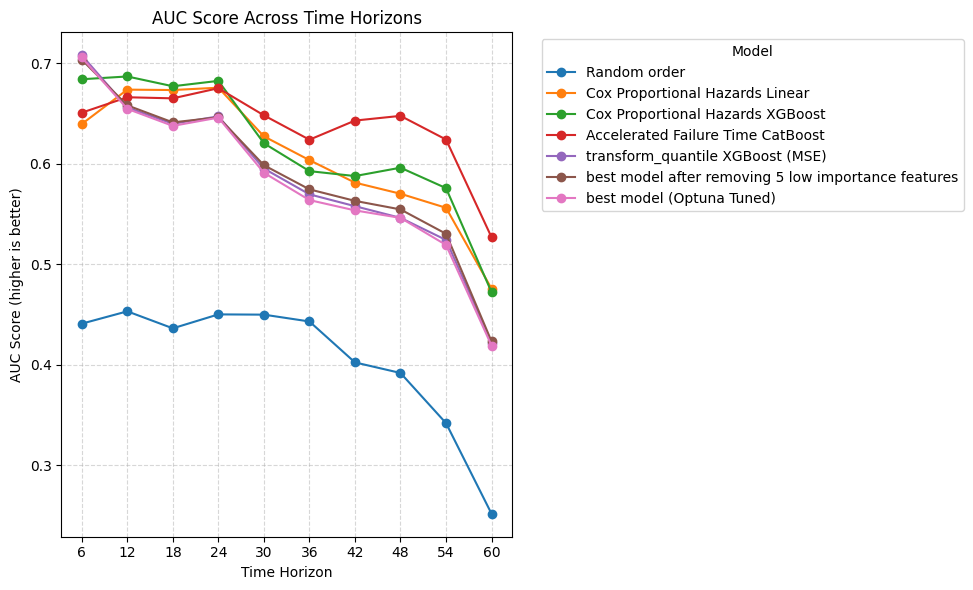

In [68]:
# Convert to DataFrame: rows = time horizons, columns = model names
df = pd.DataFrame(all_tests['aucs'])

# Sort time horizons (index) for proper line continuity
df = df.sort_index()

# Plot
plt.figure(figsize=(10, 6))
for model_name in df.columns:
    plt.plot(df.index, df[model_name], marker='o', label=model_name)

plt.xlabel("Time Horizon")
plt.ylabel("AUC Score (higher is better)")
plt.title("AUC Score Across Time Horizons")
plt.xticks(ticks=time_points)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observations:**
- Again, the `Random order` model failed completely compared to other models.
- The `Accelerated Failure Time CatBoost` stayed as the strongest model overall in t-AUC scores in both CV and test scores.
- Like in the C-index score comparison, the models' performance rankings shift quite a bit, as does their overall performance between the CV and test scores.  
    This, again, is probably due to us training and improving the models on the CV scores, and both our train and test sets being quite small.  
    But it is also due to us not trying to optimize this metric, over the C-index scores.

### Final conclusion
Overall, our models' performance did not hold as well as we wanted when testing it on the test set, but it was still way better than a random guess model.
These results are probably caused by overfitting in our training of the models, and focusing on a single metric - the C-index scores.

If we focus on the CV scores, as they were the ones we focused on throughout this notebook:  
- The best performing model in terms of C-index score became the `best model (Optuna Tuned)` - as expected.
- The best performing model in terms of t-AUC scores stayed the `Accelerated Failure Time CatBoost` against all other models.

# Conclusions

**Note on Hyperparameter Tuning**
After identifying `transform_quantile XGBoost` as our best-performing model based on both fairness and accuracy in C-index scores,  
we conducted a focused hyperparameter tuning process using the Optuna library.

This resulted in:
- A **slightly improved overall score**
- **More consistent performance across all race groups** (with a lower standard deviation),

While the boost was marginal,  
it reinforces the effectiveness of our chosen transformation and confirms that the model is close to its optimal configuration under the given data and constraints.

### Race group inequality
With most models, the **Asian** predictions get the highest scores (best concordance) and the predictions for **white** patients get the lowest scores (worst concordance). 

As the competition's objective (equitability across diverse patient populations) rewards models with similar concordance scores for all six race groups,  
a possible strategy could be to artificially make the predictions for Asian patients worse.  

### Considered But Not Implemented: Alternative Modeling Strategies
The following alternative paths offer promising directions for future refinement,  
but were set aside in favor of a simpler, interpretable, and equitable modeling workflow in this phase.

##### Feature removal and enginerring
In the EDA we removed some of the features that we deemed not useful, and combined all HLA features into one.  
We also removed the least impactful features in the Feature importance section.  
Removing more features, or returning some of the ones we removed could improve the models' performance.  
Also, the transformation of the HLA features might not be optimal, and a better one might be found, to improve the performance of the models.

Removal of more features could also reduce the overfitting we experienced when using the test set.

##### Advanced Modeling Techniques Not Pursued
Beyond our chosen models, we also considered exploring:
- **Deep learning approaches** like neural networks or deep neural networks.
- **Bayesian optimization** with uncertainty calibration.

However, these techniques require more complex infrastructure and tuning, and might compromise explainability — which is critical in healthcare settings.  
Thus, we opted for a more interpretable, well-supported model that aligns with the equity-oriented goals of the challenge.

##### Alternative Data Splitting Strategies
In this project, hyperparameter tuning and evaluation were performed via **k-fold cross-validation stratified by race group**.  
While effective for robustness, we also considered a **different approach**:
- Using **90% of the training data** for training  
- Holding out **10%** as a **fixed validation set** for hyperparameter tuning (e.g., via Optuna)  

This method could offer:
- More stable tuning across a consistent validation set  
- A setup closer to real-world deployment workflows

We chose not to pursue it this time, to avoid reducing the training sample size, but it's a viable option for future pipelines, especially if the data volume increases.

##### Focusing on t-AUC as the main metric
We could have also chosen to focus on our second metric - **t-AUC** - in our journey to improve the models.  
It would probably take us on a different path in terms of chosen models and modeling strategies.  
We chose to focus only on the first metric (**C-index**), as it was the official one given in the competition, and to have a single obvious goal to follow.

### Understanding the Model’s Modest Performance

While our model demonstrates reasonable discrimination ability,  
it’s important to acknowledge that the overall performance — measured by metrics like the Concordance Index — is not particularly close to 1.0, even after tuning.

#### Why Aren’t the Results Closer to 1?

1. **Nature of Survival Data**  
   In post-HCT survival modeling, the outcomes are inherently noisy, multifactorial, and censored.  
   Events can occur long after transplantation — or not at all — making exact prediction difficult even with rich feature sets.

2. **Synthetic or Engineered Dataset**  
   As noted earlier, the dataset used in this challenge has undergone some preprocessing or engineering.  
   It may lack certain real-world complexities, or conversely, contain oversimplifications or artifacts that limit predictive signal.  
   This can cap achievable model performance.

3. **Feature and Label Limitations**  
   - Some clinically meaningful variables may be missing, underrepresented, or approximated (e.g., disease stage granularity, treatment adherence).
   - Labels like `efs_time` reflect a mix of biological and institutional factors, making prediction inherently probabilistic.

4. **Modeling Bias Toward Fairness**  
   Our pipeline explicitly accounts for race group stratification to promote **equity** in modeling.  
   While this improves subgroup fairness, it may slightly limit global optimization — trading off small performance gains for broader inclusion and fairness.

#### Relative Success: We're in the Ballpark

It’s also worth noting that:
> **Top-performing models in the official competition achieved metrics only slightly higher than ours.**

This suggests that:
- The problem itself is intrinsically hard.
- We've successfully captured much of the predictive signal available in the dataset.
- Further marginal improvements might require fundamentally different approaches (e.g., new data, additional clinical knowledge, or ensemble meta-modeling).

In short, while our results may not seem “high” in isolation, they are **competitive within this task’s landscape** and grounded in a principled, fairness-aware methodology.

## Final words

### Working environment
As we heard many disrecommendations for Kaggle notebooks as a work environment, we immediately skipped that option.

First we tried Google collab, but it proved difficult to work in,  
as the platform has bad intellisense, and no real realtime abillities.

We decided to switch to a rather newer option, Deepnote.  
It was easier to work there, due to having built in intellisense, realtime collaboration, and pretty UI.  
But for some reason, they made it really hard to work with text/markdown blocks.

We ended up working locally in VSCode by setting up a virtual environment,  
and using the Live Share extension for realtime collaboration.  
It wasn't super hard to set up, and is pretty easy to work with.  
So in the future, we will start with this option.

### Personal conclusions
Beyond the technical choices and modeling challenges,  
this project served as an opportunity to reflect on what it means to build **fair, responsible, and interpretable machine learning models in healthcare**.  
Rather than focusing solely on marginal metric gains, we prioritized equity across demographic groups, transparent evaluation, and principled decision-making.  
This approach may not always lead to leaderboard dominance, but it lays a foundation for real-world impact and trustworthy science.

Throughout this journey, we’ve deepened not only our understanding of **data science and machine learning techniques**, but also of the **ethical dimensions of AI**.  
The experience reminded us that behind every data point is a patient — and that thoughtful modeling isn’t just about accuracy, but about responsibility.  
Questions of fairness, bias, and impact aren’t peripheral to our work as data scientists — they are central to doing it well.  